In [1]:
%reset -sf

import tensorflow as tf
import tf_keras
print("Tensorflow:", tf.__version__)
import tensorflow_probability as tfp
print("Tensorflow Probability:", tfp.__version__)

# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_376 / 3 # Set the memory limit in MB
        # memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2025-03-01 15:46:30.239667: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 15:46:30.260933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.16.1
Tensorflow Probability: 0.24.0
1 Physical GPUs, 1 Logical GPU


2025-03-01 15:46:31.631662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import paper_plot as pp

plot = pp.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import cauchy, skewnorm

SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [ ]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
mc_weight = data.MC_weight()

['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']


In [ ]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22 # 22 ~ 40 (SY)
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# # define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > -9999
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)


0
29961
44269
89634
157782


In [ ]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
	[truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
	axis=1,
).to_numpy()
truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
	[truth_sublead_lep_px, truth_sublead_lep_py, truth_sublead_lep_pz, truth_sublead_lep_energy],
	axis=1,
).to_numpy()
# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
	[lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
	axis=1,
).to_numpy()
sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
	[sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
	axis=1,
).to_numpy()

In [ ]:

## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        lead_lep.pz,
        lead_lep.energy,
        sublead_lep.px,
        sublead_lep.py,
        sublead_lep.pz,
        sublead_lep.energy,
        # np.log(sublead_lep.energy),
        # np.log(lead_lep.energy),
        # lead_lep.eta,
        # sublead_lep.eta,
        met.px,
        met.py,
    )
)[PRE_CUT]

# weights
mc_weight = mc_weight.w.to_numpy()[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

# ROBUST_OBS = RobustScaler()
# obs_kin = ROBUST_OBS.fit_transform(obs_kin)
# print(type(obs_kin))

int_kin shape: (851115, 10)


In [ ]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        # w_lead_m,
        # w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (851115, 8)
<class 'numpy.ndarray'>


In [ ]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)

train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 851115
X (Interest)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).
Y (Observed)
Training data shape: (680892, 8);
Validing data shape: (85111, 8);
Testing data shape: (85112, 8).


In [ ]:
# training variables
BATCH_SIZE = 512
EPOCHS = 1024
LEARNING_RATE = 1e-5

# create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_x, tf.float32), 
    tf.cast(train_y, tf.float32)
)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(valid_x, tf.float32), 
    tf.cast(valid_y, tf.float32)
)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

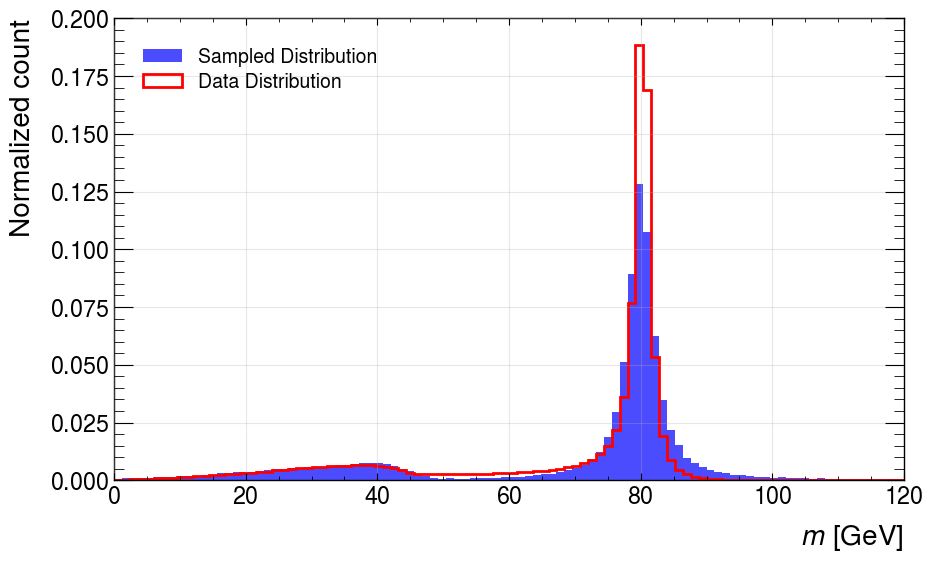

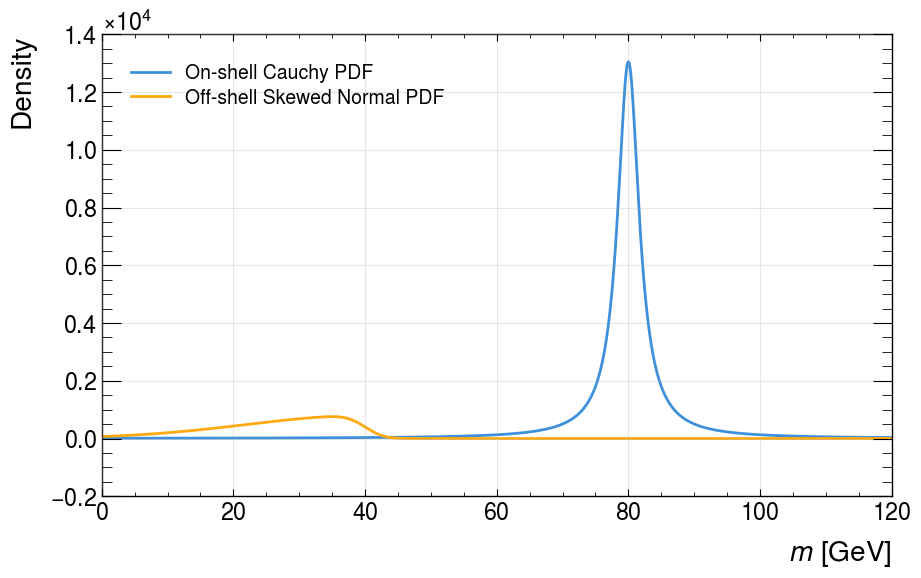

In [ ]:
# Sampling parameters (consistent with your data)
n_samples = 100000
on_shell_fraction = 0.82
n_on_shell = int(n_samples * on_shell_fraction)
n_off_shell = n_samples - n_on_shell 

# Generate sampled distribution for reference (optional validation)
on_shell_samples = cauchy.rvs(loc=80, scale=2, size=n_on_shell)
off_shell_samples = skewnorm.rvs(a=-8, loc=45, scale=20, size=n_off_shell)
off_shell_samples = off_shell_samples[
    (off_shell_samples >= 0) & (off_shell_samples <= 125)
]
samples = np.concatenate([on_shell_samples, off_shell_samples])
samples = samples[(samples >= 0) & (samples <= 120)]

# Plotting the sampled and data distribution
plt.figure(figsize=(10, 6))
bins_edges = np.linspace(0, 120, 101)
plt.hist(
    samples,
    bins=bins_edges,
    color="blue",
    alpha=0.7,
    label="Sampled Distribution",
    density=True,
)
plt.hist(
    w_lead_m,
    bins=bins_edges,
    color="red",
    histtype="step",
    linewidth=2,
    alpha=1.0,
    label="Data Distribution",
    density=True,
)
plt.xlabel(r"$m$ [GeV]")
plt.ylabel("Normalized count")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot PDF for visual inspection
x = np.linspace(0, 120, 1000)
plt.figure(figsize=(10, 6))
plt.plot(
    x, cauchy.pdf(x, loc=80, scale=2) * n_on_shell, label="On-shell Cauchy PDF"
)
plt.plot(
    x,
    skewnorm.pdf(x, a=-8, loc=40, scale=18) * n_off_shell,
    label="Off-shell Skewed Normal PDF",
)
plt.xlabel(r"$m$ [GeV]")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Define the anticipated distribution shape (mixture model)
x_grid = tf.linspace(0.0, 120.0, 1000)
x_grid = tf.cast(x_grid, dtype=tf.float32) # Explicitly set dtype
on_shell_pdf = cauchy.pdf(x_grid, loc=80.0, scale=2.0) * on_shell_fraction
off_shell_pdf = skewnorm.pdf(x_grid, a=-8.0, loc=45.0, scale=20.0) * (
    1.0 - on_shell_fraction
)
total_pdf = on_shell_pdf + off_shell_pdf
total_pdf = total_pdf / tf.reduce_max(total_pdf)  # Normalize
total_pdf_tf = tf.cast(total_pdf, dtype=tf.float32)  # Ensure consistent dtype


# Loss functions
def nu_mass_loss_fn(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]

    nu0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(n0_4vect[..., 3])
                - tf.reduce_sum(tf.square(n0_4vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )
    nu1_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(n1_4vect[..., 3])
                - tf.reduce_sum(tf.square(n1_4vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )

    return tf.reduce_mean(nu0_mass + nu1_mass)


def dinu_pt_loss_fn(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]

    nn_4vect = n0_4vect + n1_4vect
    nn_px = nn_4vect[..., 0]
    nn_py = nn_4vect[..., 1]

    nn_px_diff = tf.math.maximum(tf.abs(nn_px - x_batch[..., 8]), _epsilon)
    nn_py_diff = tf.math.maximum(tf.abs(nn_py - x_batch[..., 9]), _epsilon)

    return tf.reduce_mean(nn_px_diff + nn_py_diff)


def higgs_mass_loss_fn(y_pred):
    _epsilon = 1e-10
    y_pred = tf.cast(y_pred, tf.float32)

    w0_4Vect = y_pred[..., :4]
    w1_4Vect = y_pred[..., 4:8]
    higgs_4Vect = w0_4Vect + w1_4Vect

    higgs_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(higgs_4Vect[..., 3])
                - tf.reduce_sum(tf.square(higgs_4Vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )

    return tf.reduce_mean(tf.abs(higgs_mass - 125.0)) + _epsilon


def w_mass_loss_fn(y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    w0_4Vect = y_pred[..., :4]
    w0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(w0_4Vect[..., 3])
                - tf.reduce_sum(tf.square(w0_4Vect[..., :3]), axis=-1)
            ),
            1e-10,
        )
    )

    # NLL for the anticipated distribution shape
    pred_masses = tf.reshape(w0_mass, [-1])  # Focus on w0_mass
    # pred_masses = tf.cast(pred_masses, tf.float32)  # Ensure dtype consistency
    pred_pdf = tfp.math.interp_regular_1d_grid(
        pred_masses, 0.0, 120.0, total_pdf_tf, fill_value=1e-10
    )
    # Negative log-likelihood penalty
    nll = -tf.reduce_mean(tf.math.log(pred_pdf + 1e-10))

    return nll


def mae_loss_fn(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.keras.losses.mae(y_true, y_pred))

In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.current_epoch = tf.Variable(0.0, trainable=False)
        
        # Initialize metrics dictionary with lambda_weight
        self.metric_dict = {
            'mae1_loss': tf.keras.metrics.Mean(name='mae1_loss'),
            # 'mae2_loss': tf.keras.metrics.Mean(name='mae2_loss'),
            'nu_mass_loss': tf.keras.metrics.Mean(name='nu_mass_loss'),
            'w_mass_loss': tf.keras.metrics.Mean(name='w_mass_loss'),
            'higgs_mass_loss': tf.keras.metrics.Mean(name='higgs_mass_loss'),
            'dinu_pt_loss': tf.keras.metrics.Mean(name='dinu_pt_loss'),
            # 'fused_output_loss': tf.keras.metrics.Mean(name='fused_output_loss'),
            'loss': tf.keras.metrics.Mean(name='loss'),
            # 'lambda_weight': tf.keras.metrics.Mean(name='lambda_weight')  # Track mean lambda
        }

    def call(self, inputs, training=None):
        return self.base_model(inputs, training=training)
    
    def compile(self, optimizer, loss_weights=None, **kwargs):
        super().compile(optimizer=optimizer, **kwargs)
        default_weights = {
            'mae1': 1.0,
            'mae2': 1.0,
            'nu_mass': 1.0,
            'higgs_mass': 1.0,
            'w_mass': 1.0,
            'dinu_pt': 1.0,
            'fused_output': 1.0
        }
        self.loss_weights = {**default_weights, **(loss_weights or {})}

    @property
    def metrics(self):
        return list(self.metric_dict.values())

    def _compute_losses(self, x, y, predictions):
        # Unpack four outputs: [fused_output, nu_mass_output, mae_output, lambda_weight]
        outputs = predictions
        
        losses = {
            'mae1': mae_loss_fn(y, outputs),  # Use mae_output for MAE net(adjust if needed)
            # 'mae2': mae_loss_fn(y, outputs),  # Use nu_mass net  for MAE (adjust if needed)
            'nu_mass': nu_mass_loss_fn(x, outputs),
            'higgs_mass': higgs_mass_loss_fn(outputs),
            'w_mass': w_mass_loss_fn(outputs),
            'dinu_pt': dinu_pt_loss_fn(x, outputs),
            # 'fused_output': mae_loss_fn(y, outputs)
        }
        
        total_loss = tf.add_n([
            self.loss_weights[name] * loss for name, loss in losses.items()
        ])
        
        return total_loss, losses

    def _update_metrics(self, total_loss, losses):
        """Helper method to update metrics"""
        self.metric_dict['loss'].update_state(total_loss)
        for name, loss in losses.items():
            self.metric_dict[f'{name}_loss'].update_state(loss)
        # self.metric_dict['lambda_weight'].update_state(tf.reduce_mean(lambda_weight))  # Track mean

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            total_loss, losses = self._compute_losses(x, y, predictions)

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # self.current_epoch.assign_add(1.0)
        self._update_metrics(total_loss, losses)
        
        return {name: metric.result() for name, metric in self.metric_dict.items()}

    def test_step(self, data):
        x, y = data
        predictions = self(x, training=False)
        total_loss, losses = self._compute_losses(x, y, predictions)
        
        self._update_metrics(total_loss, losses)
        
        return {name: metric.result() for name, metric in self.metric_dict.items()}

In [ ]:
# Define the WBosonFourVectorLayer (as provided earlier)
class WBosonFourVectorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WBosonFourVectorLayer, self).__init__(**kwargs)

    def call(self, inputs):
        lep0, lep1, nu_3mom = inputs
        nu0_3mom = nu_3mom[..., :3]  # [px, py, pz] for nu0
        nu1_3mom = nu_3mom[..., 3:]  # [px, py, pz] for nu1
        nu0_p_squared = tf.reduce_sum(tf.square(nu0_3mom), axis=-1, keepdims=True)
        nu1_p_squared = tf.reduce_sum(tf.square(nu1_3mom), axis=-1, keepdims=True)
        nu0_energy = tf.sqrt(tf.maximum(nu0_p_squared, 1e-10))
        nu1_energy = tf.sqrt(tf.maximum(nu1_p_squared, 1e-10))
        nu0_4vect = tf.concat([nu0_3mom, nu0_energy], axis=-1)
        nu1_4vect = tf.concat([nu1_3mom, nu1_energy], axis=-1)
        w0_4vect = lep0 + nu0_4vect
        w1_4vect = lep1 + nu1_4vect
        return tf.concat([w0_4vect, w1_4vect], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], 8)

In [ ]:
def dense_dropout_block(x, units, activation="swish", dropout_rate=0.0, l2=0.0):
    x = tf.keras.layers.Dense(
        units=units,
        use_bias=True,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.L2(l2),
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    if dropout_rate > 0:    
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    return x

def residual_block(x, units, activation="swish", dropout_rate=0.0, l2=0.0):
    y = dense_dropout_block(x, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    y = dense_dropout_block(y, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    if x.shape[-1] != units:
        x = tf.keras.layers.Dense(units, activation=None, use_bias=False)(x)
    z = tf.keras.layers.Add()([x, y]) 
    z = tf.keras.layers.BatchNormalization()(z) 
    z = tf.keras.layers.Activation(activation)(z)
    return z

In [ ]:
def build_model(input_shape):
    inputs = tf.keras.layers.Input(shape=(input_shape,), dtype=tf.float32)
    x, y = inputs, inputs
    
    # Extract lepton 4-vectors for Subnet 1
    lep0 = inputs[..., :4]  # [px, py, pz, e] for leading lepton
    lep1 = inputs[..., 4:8]  # [px, py, pz, e] for subleading lepton
    
    # Subnet 1 --> Predict neutrino 3-momenta and apply physics layer
    for _ in range(2):
        x = residual_block(x, 128, dropout_rate=0.3, l2=1e-5)
        x = residual_block(x, 64, dropout_rate=0.3, l2=1e-5)
    for _ in range(1):
        # x = residual_block(x, 512, dropout_rate=0.3, l2=1e-5)
        x = residual_block(x, 256, dropout_rate=0.3, l2=1e-5)
    for _ in range(2):
        x = residual_block(x, 64, dropout_rate=0.3, l2=1e-5)
        x = residual_block(x, 32, dropout_rate=0.3, l2=1e-5)
    # Bottleneck
    x = tf.keras.layers.Dense(16, activation=None, kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("swish")(x)
    nu_3mom = tf.keras.layers.Dense(units=6, activation="linear", kernel_initializer='he_normal')(x)
    outputs = WBosonFourVectorLayer()([lep0, lep1, nu_3mom])
    
    return tf.keras.Model(inputs=inputs, outputs=[outputs])

In [ ]:
# # Add TensorBoard import at the top with other imports
# from datetime import datetime

# # In the callbacks section:
# current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir = f"{HOME_PATH}/10th_trial/logs/{current_time}"

# Build and compile model
input_shape = train_x.shape[-1]
base_model = build_model(input_shape)
model = CustomModel(base_model)
model.build((None, input_shape))
model.summary()

# Model compilation with weights dictionary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_weights={
        'mae1': 1.0,
        'nu_mass': 0.0,
        'higgs_mass': 0.0,
        'w_mass': 0.5,
        'dinu_pt': 0.0,
    },
    jit_compile=True,
    steps_per_execution=256,
)

# Updated callbacks
class EpochUpdater(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.model.current_epoch.assign(float(epoch))

class LambdaTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch_num = int(self.model.current_epoch.numpy())
        log_str = f"Epoch {epoch_num}"
        # Log all metrics
        for name, value in logs.items():
            log_str += f"; {name}: {value:.4f}"
        print(log_str)

# class DebugLogger(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         current_epoch = self.model.current_epoch.numpy()
#         test_log_term = tf.math.log(tf.cast(current_epoch + 21.0, tf.float32)) - 3.0
#         print(f"Epoch {current_epoch}; Log factor: {test_log_term:.4f}; Mass loss: {logs['mass_loss']:.4f}")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    EpochUpdater(),
    LambdaTracker(),
    # tf.keras.callbacks.TensorBoard(
    #     log_dir=log_dir,
    #     histogram_freq=1,
    #     write_graph=True,
    #     write_images=True,
    #     update_freq='epoch',
    #     profile_batch=0,
    #     embeddings_freq=0,
    # ),
]

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=0,
)

# Print the weights
print("\nModel Loss Weights:")
for name, weight in model.loss_weights.items():
    print(f"{name:12s}: {weight:.3f}")

Model: "custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8)              │       258,614 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,614 (1010.21 KB)

 Trainable params: 253,590 (990.59 KB)

 Non-trainable params: 5,024 (19.62 KB)

Epoch 0; dinu_pt_loss: 67.0946; higgs_mass_loss: 81.7108; loss: 40.0133; mae1_loss: 37.6569; nu_mass_loss: 0.0021; val_dinu_pt_loss: 67.0748; val_higgs_mass_loss: 83.9773; val_loss: 39.8743; val_mae1_loss: 37.5629; val_nu_mass_loss: 0.0017; val_w_mass_loss: 4.6227; w_mass_loss: 4.7127
Epoch 1; dinu_pt_loss: 67.0980; higgs_mass_loss: 80.5002; loss: 39.8590; mae1_loss: 37.6057; nu_mass_loss: 0.0026; val_dinu_pt_loss: 67.0768; val_higgs_mass_loss: 82.7266; val_loss: 39.7370; val_mae1_loss: 37.5169; val_nu_mass_loss: 0.0022; val_w_mass_loss: 4.4401; w_mass_loss: 4.5067
Epoch 2; dinu_pt_loss: 67.0793; higgs_mass_loss: 79.4660; loss: 39.7491; mae1_loss: 37.5557; nu_mass_loss: 0.0030; val_dinu_pt_loss: 67.0780; val_higgs_mass_loss: 81.6123; val_loss: 39.6309; val_mae1_loss: 37.4739; val_nu_mass_loss: 0.0026; val_w_mass_loss: 4.3140; w_mass_loss: 4.3869
Epoch 3; dinu_pt_loss: 67.0214; higgs_mass_loss: 78.3255; loss: 39.6419; mae1_loss: 37.4983; nu_mass_loss: 0.0033; val_dinu_pt_loss: 67.0770; 

I0000 00:00:1740843820.471982  883518 service.cc:145] XLA service 0x73fa080559a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740843820.471996  883518 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-01 15:43:40.634987: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-01 15:43:41.376926: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1740843827.191225  883717 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1740843827.327826  883712 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:17

In [ ]:
# Make a directory
dir_name = HOME_PATH + "/11th_trial/ww_resregressor_result/" 
savedmodel_path = dir_name + "saved_model"
name = "ww_resregressor"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)
tf.saved_model.save(model, savedmodel_path) # save model in saved_model format --> use in the onnx 

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/11th_trial/ww_resregressor_result/ cleaned.
Directory /root/work/QE-mls/11th_trial/ww_resregressor_result/ exists.
INFO:tensorflow:Assets written to: /root/work/QE-mls/11th_trial/ww_resregressor_result/saved_model/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/11th_trial/ww_resregressor_result/saved_model/assets


2660/2660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


2025-03-01 15:44:49.305239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


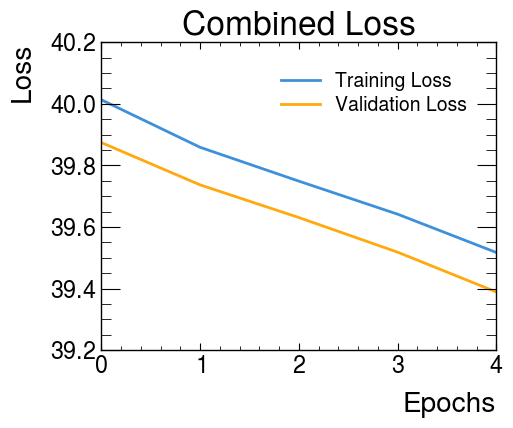

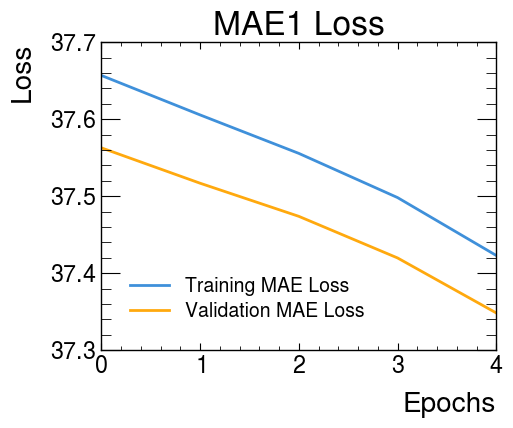

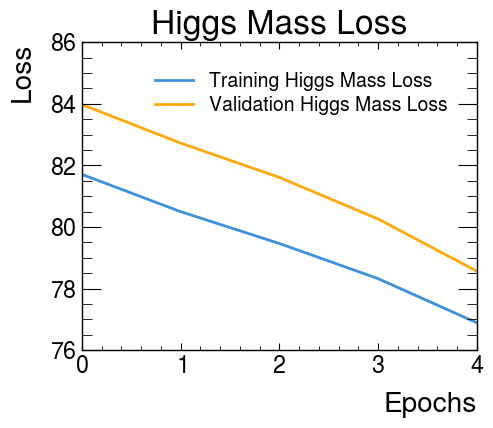

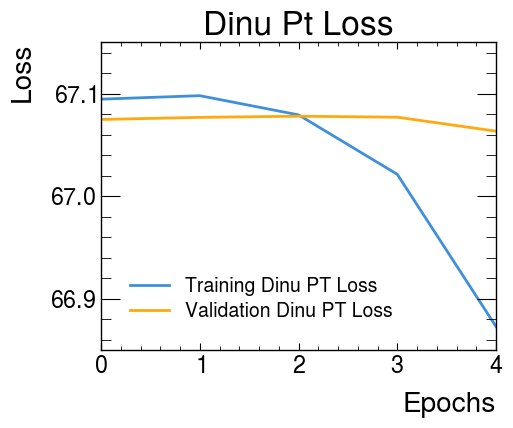

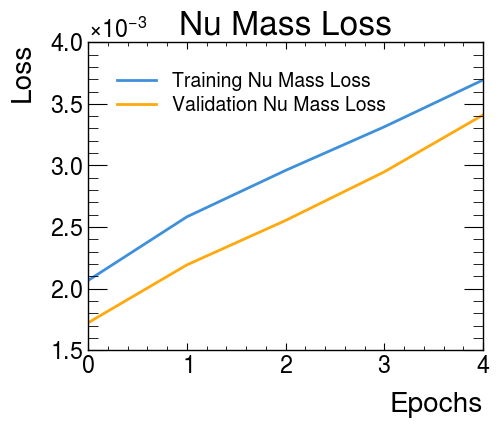

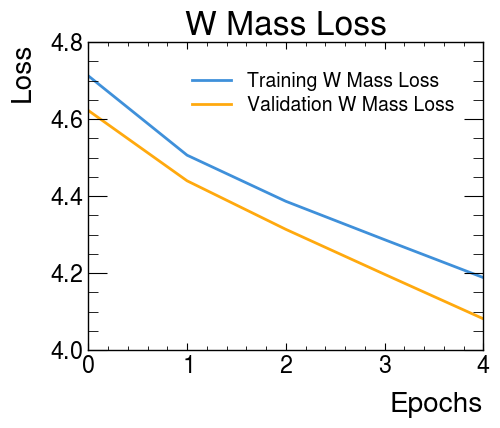

In [ ]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]
mae1_loss = history.history["mae1_loss"]
val_mae1_loss = history.history["val_mae1_loss"]
# mae2_loss = history.history["mae2_loss"]
# val_mae2_loss = history.history["val_mae2_loss"]
higgs_mass_loss = history.history["higgs_mass_loss"]
val_higgs_mass_loss = history.history["val_higgs_mass_loss"]
dinu_pt_loss = history.history["dinu_pt_loss"]
val_dinu_pt_loss = history.history["val_dinu_pt_loss"]
nu_mass_loss = history.history["nu_mass_loss"]
val_nu_mass_loss = history.history["val_nu_mass_loss"]
w_mass_loss = history.history["w_mass_loss"]
val_w_mass_loss = history.history["val_w_mass_loss"]

# 1) Plot combined training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Loss")
plt.legend()
plt.grid(False)
plt.show()

# 2) Plot mae training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mae1_loss, label="Training MAE Loss")
plt.plot(val_mae1_loss, label="Validation MAE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MAE1 Loss")
plt.legend()
plt.grid(False)
plt.show()

# 3) Plot mae training and validation loss
# plt.figure(figsize=(5, 4))
# plt.plot(mae2_loss, label="Training MAE Loss")
# plt.plot(val_mae2_loss, label="Validation MAE Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("MAE2 Loss")
# plt.legend()
# plt.grid(False)
# plt.show()

# 3) Plot higgs mass training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(higgs_mass_loss, label="Training Higgs Mass Loss")
plt.plot(val_higgs_mass_loss, label="Validation Higgs Mass Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Higgs Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 4) Plot dinu pt loss
plt.figure(figsize=(5, 4))
plt.plot(dinu_pt_loss, label="Training Dinu PT Loss")
plt.plot(val_dinu_pt_loss, label="Validation Dinu PT Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Dinu Pt Loss")
plt.legend()
plt.grid(False)
plt.show()

# # 5) Plot fused output loss
# plt.figure(figsize=(5, 4))
# plt.plot(fused_output_loss, label="Training Fused Output Loss")
# plt.plot(val_fused_output_loss, label="Validation Fused Output Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Fused Output Loss")
# plt.legend()
# plt.grid(False)
# plt.show()

# 6) Plot nu mass loss
plt.figure(figsize=(5, 4))
plt.plot(nu_mass_loss, label="Training Nu Mass Loss")
plt.plot(val_nu_mass_loss, label="Validation Nu Mass Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Nu Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 7) Plot w mass loss
plt.figure(figsize=(5, 4))
plt.plot(w_mass_loss, label="Training W Mass Loss")
plt.plot(val_w_mass_loss, label="Validation W Mass Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("W Mass Loss")
plt.legend()
plt.grid(False)
plt.show()



In [ ]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

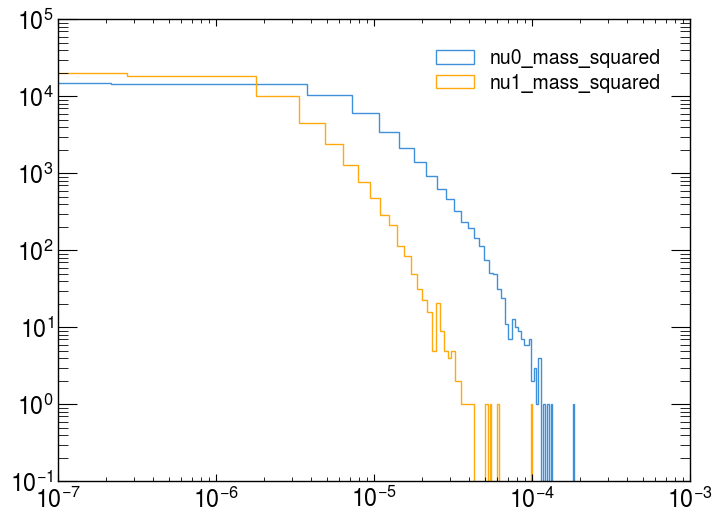

nu0_mass_squared avg: 6.850841767456768e-09
nu1_mass_squared avg: -1.5480139723639428e-09


In [ ]:
# neutrino mass checking
nu0_4vect = sig_pred_inv[:, :4] - test_x[:, :4]
nu1_4vect = sig_pred_inv[:, 4:8] - test_x[:, 4:8]
nu0_mass_squared = np.square(nu0_4vect[:, 3]) - np.square(nu0_4vect[:, 0]) - np.square(nu0_4vect[:, 1]) - np.square(nu0_4vect[:, 2])
nu1_mass_squared = np.square(nu1_4vect[:, 3]) - np.square(nu1_4vect[:, 0]) - np.square(nu1_4vect[:, 1]) - np.square(nu1_4vect[:, 2])
# nu0_mass_squared
plt.hist(nu0_mass_squared, bins=100, histtype="step", label="nu0_mass_squared")
plt.hist(nu1_mass_squared, bins=100, histtype="step", label="nu1_mass_squared")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

print("nu0_mass_squared avg:", np.mean(nu0_mass_squared))
print("nu1_mass_squared avg:", np.mean(nu1_mass_squared))
# plt.hist(nu1_mass_squared, bins=100, range=(0, 100), histtype="step", label="nu1_mass_squared")


True mean: 0.031, std: 39.544, min: -585.857, max: 803.254


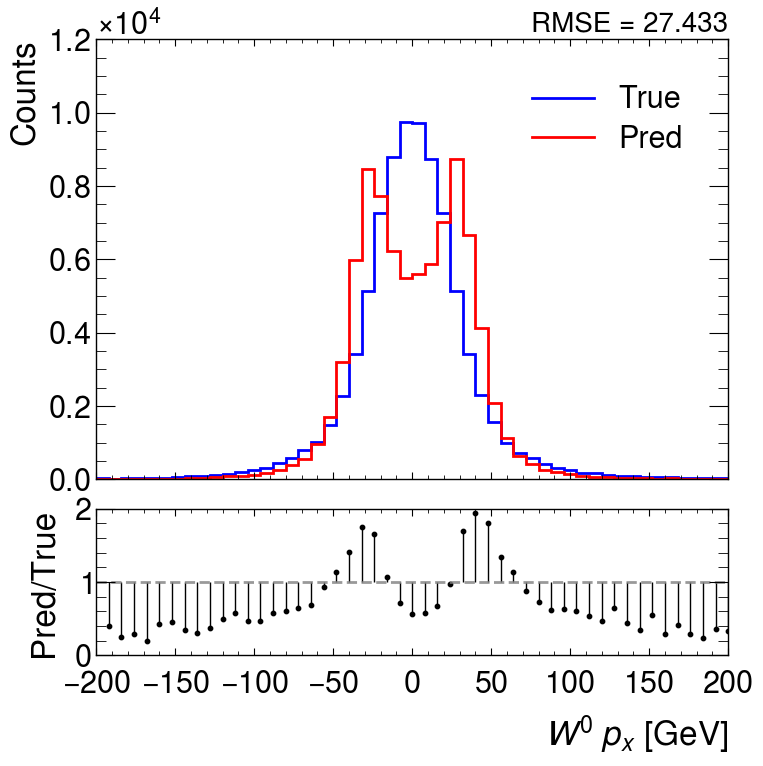

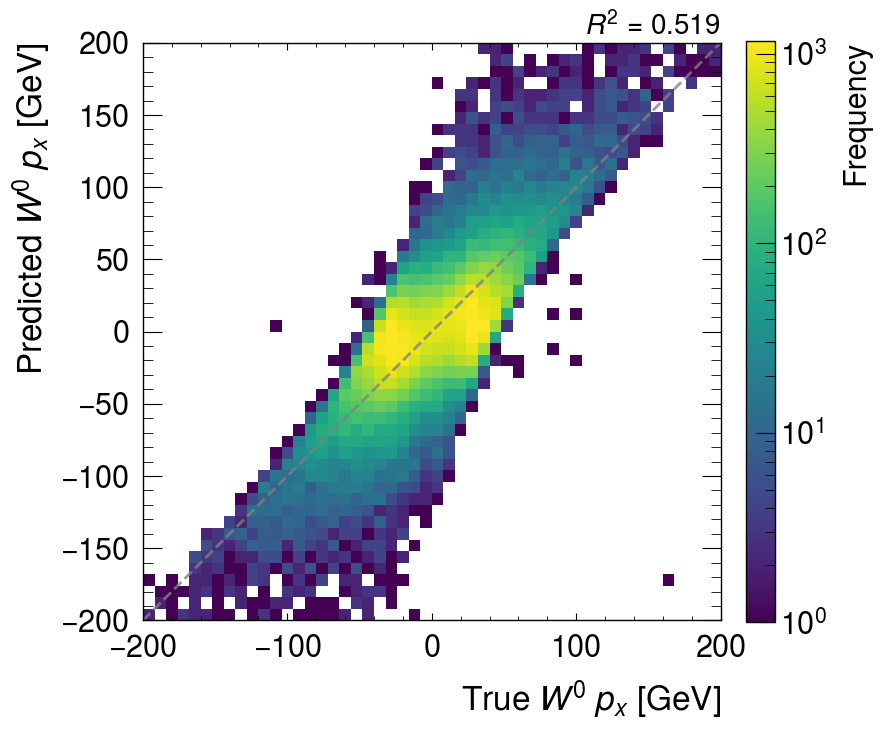

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,0], sig_pred_inv[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{x}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,0], sig_pred_inv[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,0], sig_pred_inv[:,0]):.3f}",
    xlabel="True $W^{0}\ p_{x}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{x}$ [GeV]",
    ranges=set_range
)

True mean: -0.124, std: 27.801, min: -399.814, max: 373.865


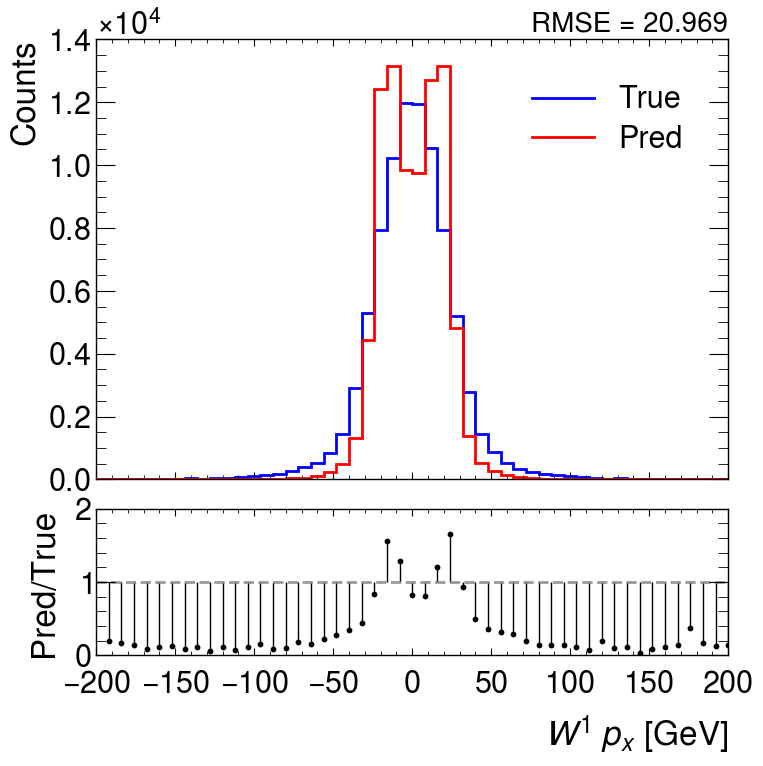

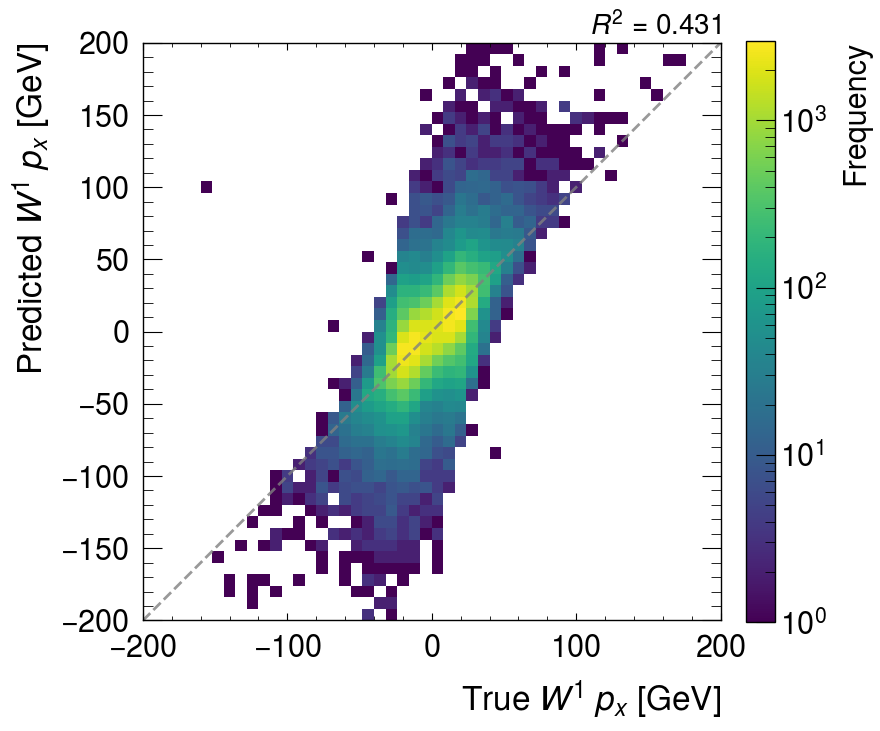

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [-200, 200]


plot.hist_1d(
    sig_truth_inv[:,4], sig_pred_inv[:,4],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{x}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,4], sig_pred_inv[:,4],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,4], sig_pred_inv[:,4]):.3f}",
    xlabel="True $W^{1}\ p_{x}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{x}$ [GeV]",
    ranges=set_range
)

True mean: -0.013, std: 39.620, min: -755.579, max: 609.143


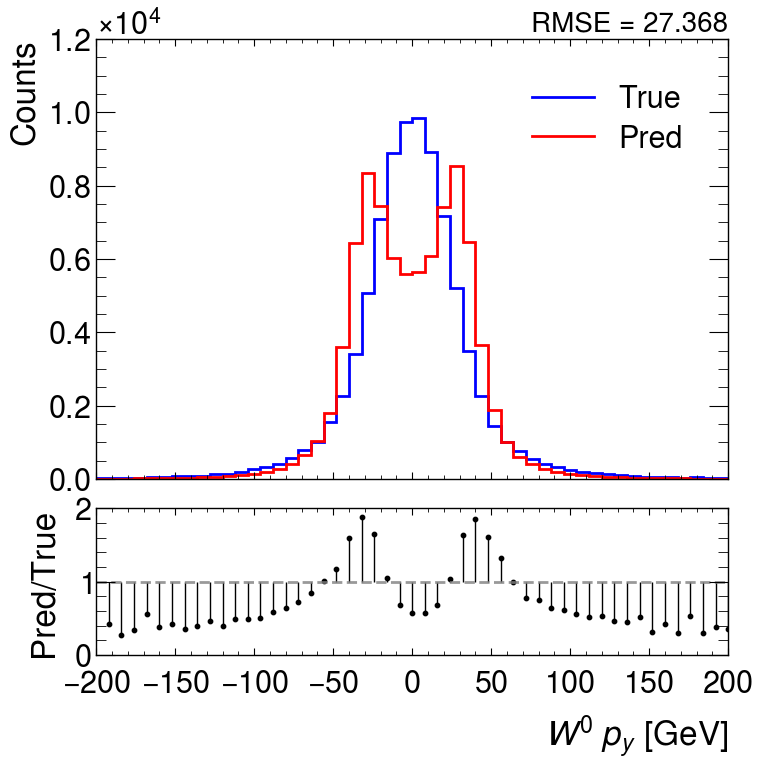

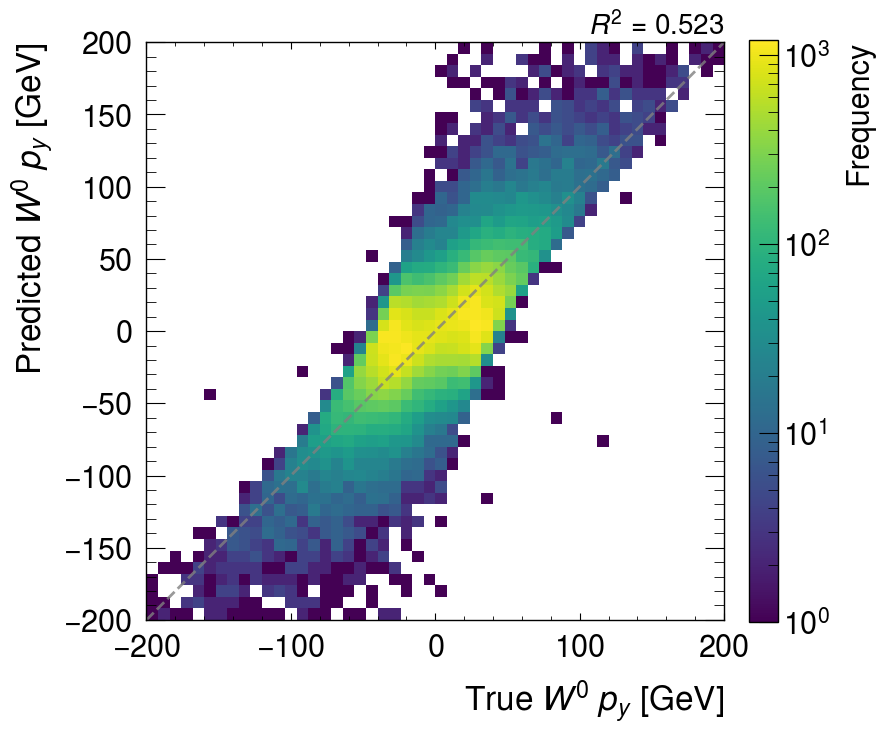

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,1], sig_pred_inv[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{y}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,1], sig_pred_inv[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,1], sig_pred_inv[:,1]):.3f}",
    xlabel="True $W^{0}\ p_{y}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{y}$ [GeV]",
    ranges=set_range
)

True mean: 0.031, std: 27.968, min: -417.838, max: 580.447


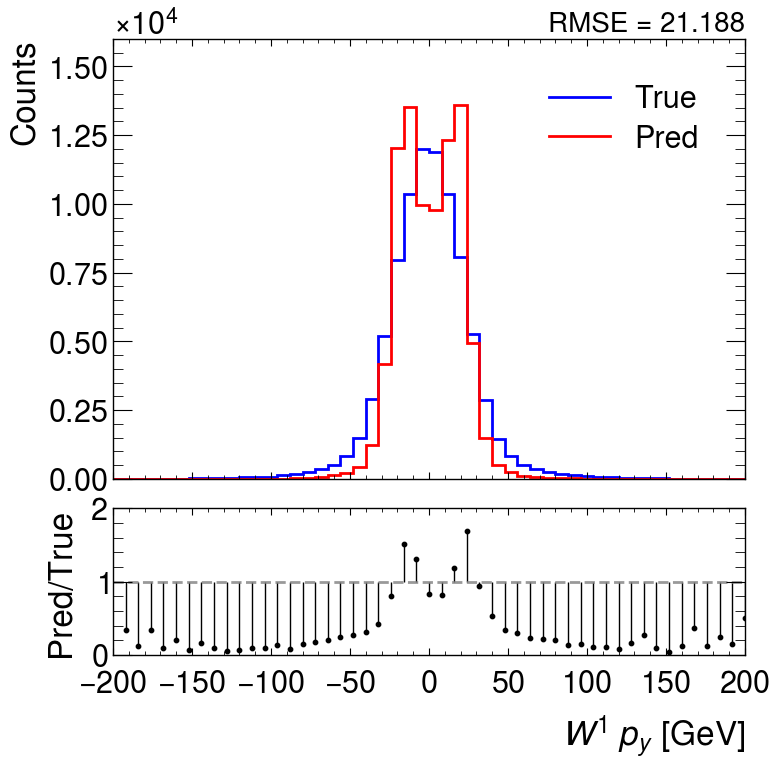

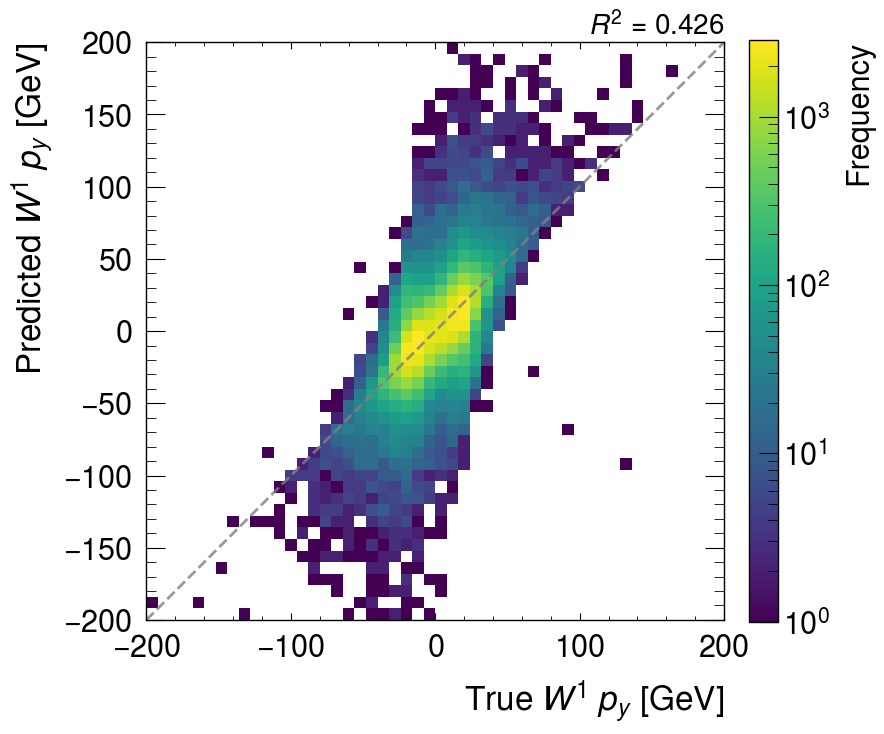

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,5], sig_pred_inv[:,5],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{y}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,5], sig_pred_inv[:,5],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,5], sig_pred_inv[:,5]):.3f}",
    xlabel="True $W^{1}\ p_{y}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{y}$ [GeV]",
    ranges=set_range
)

True mean: 0.308, std: 170.752, min: -1446.473, max: 1754.351


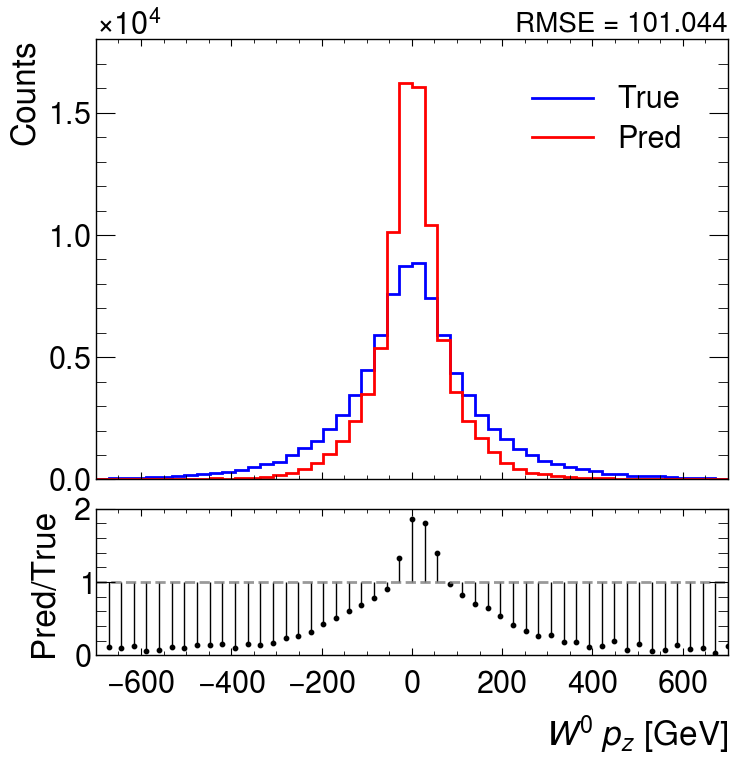

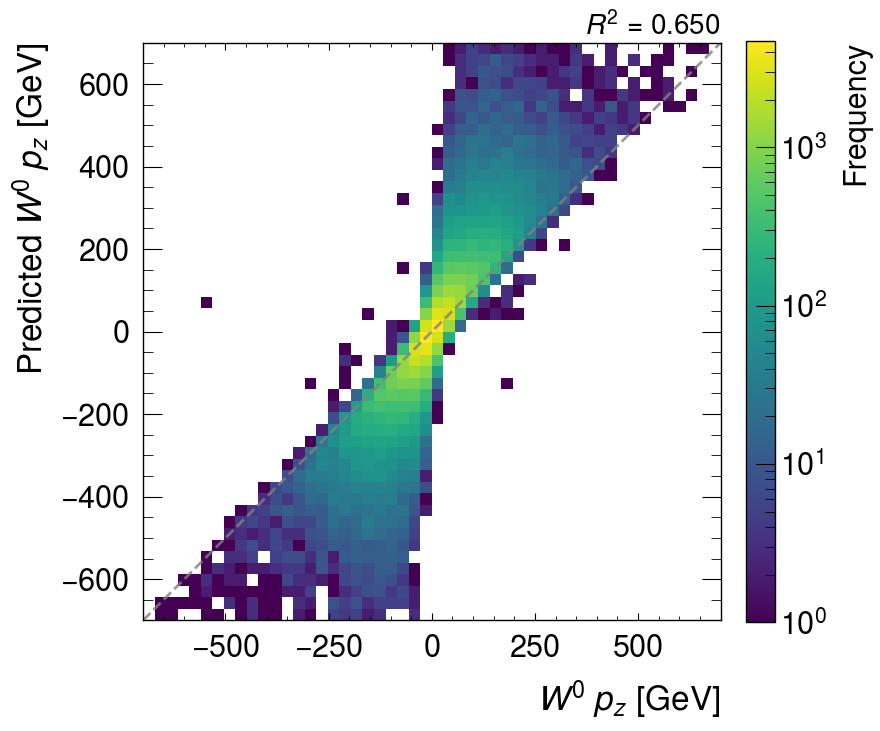

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist_1d(
    sig_truth_inv[:,2], sig_pred_inv[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{z}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,2], sig_pred_inv[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,2], sig_pred_inv[:,2]):.3f}",
    xlabel="$W^{0}\ p_{z}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{z}$ [GeV]",
    ranges=set_range
)

Truth mean: -0.337, std: 110.947, min: -1170.774, max: 1427.069


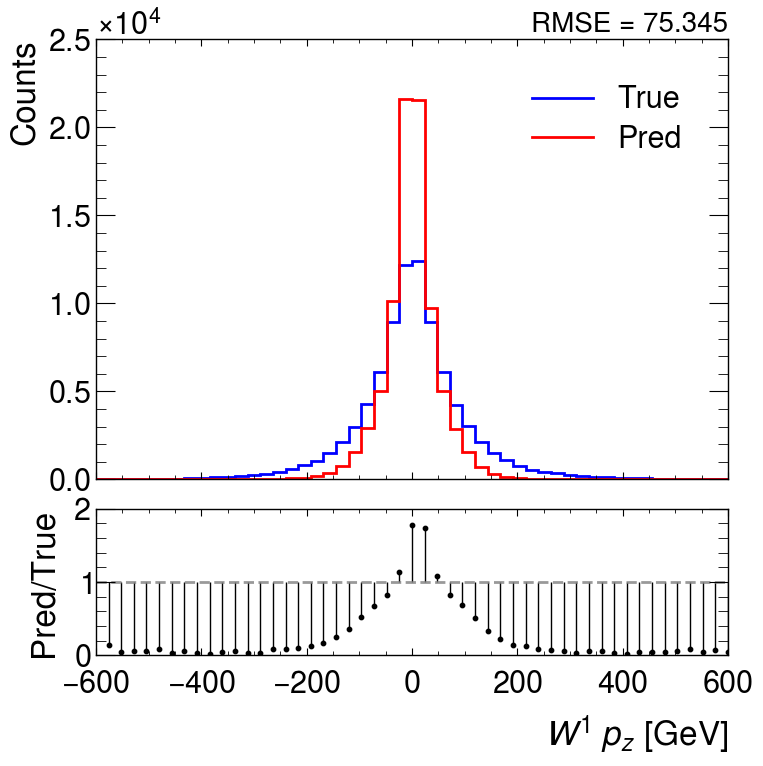

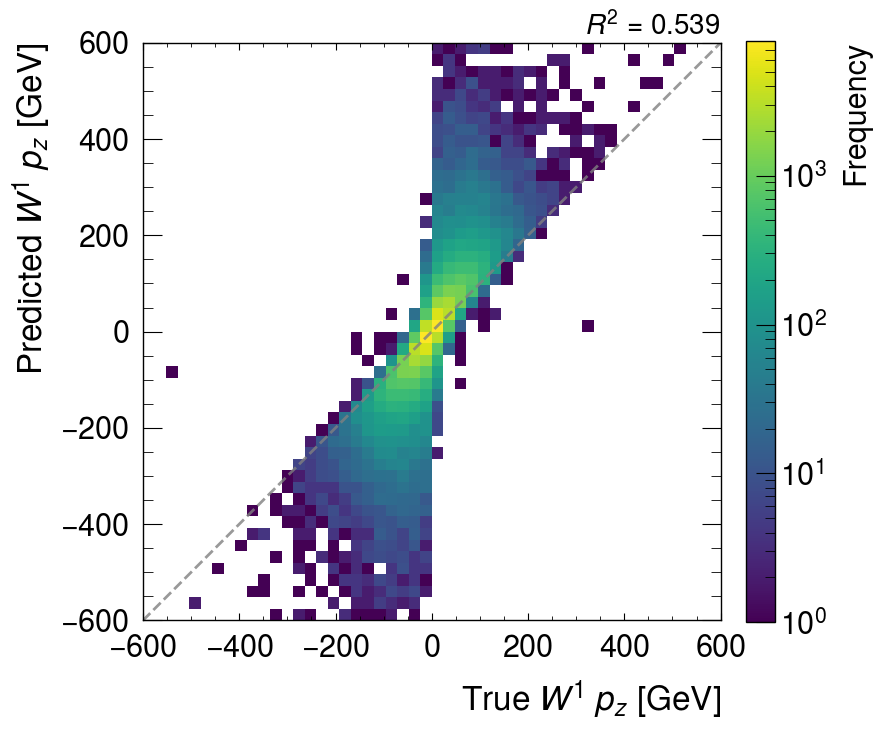

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-600, 600]

plot.hist_1d(
    sig_truth_inv[:,6], sig_pred_inv[:,6],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{z}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,6], sig_pred_inv[:,6],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,6], sig_pred_inv[:,6]):.3f}",
    xlabel="True $W^{1}\ p_{z}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{z}$ [GeV]",
    ranges=set_range
)

True mean: 158.446, std: 111.648, min: 21.707, max: 1791.292


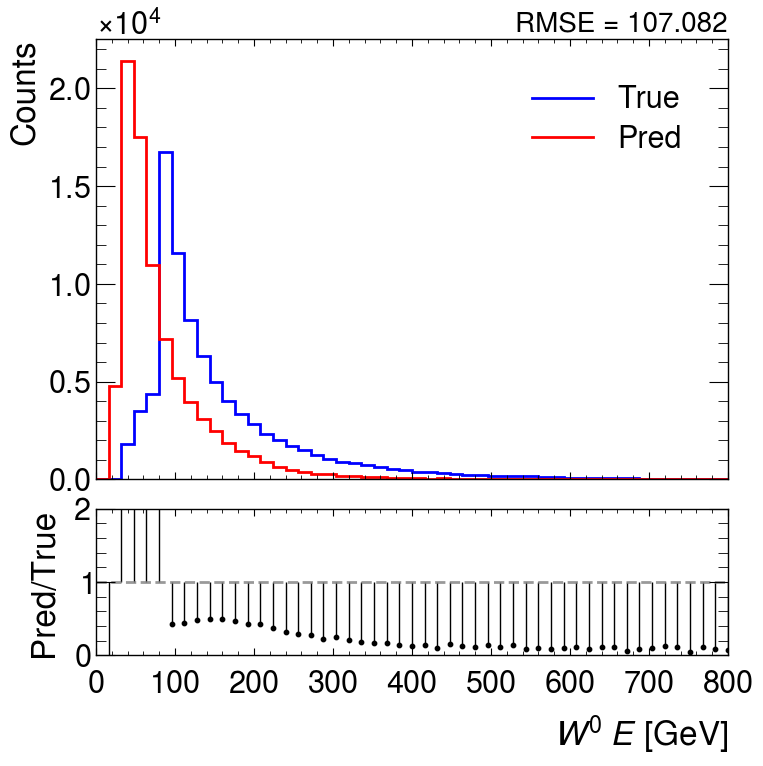

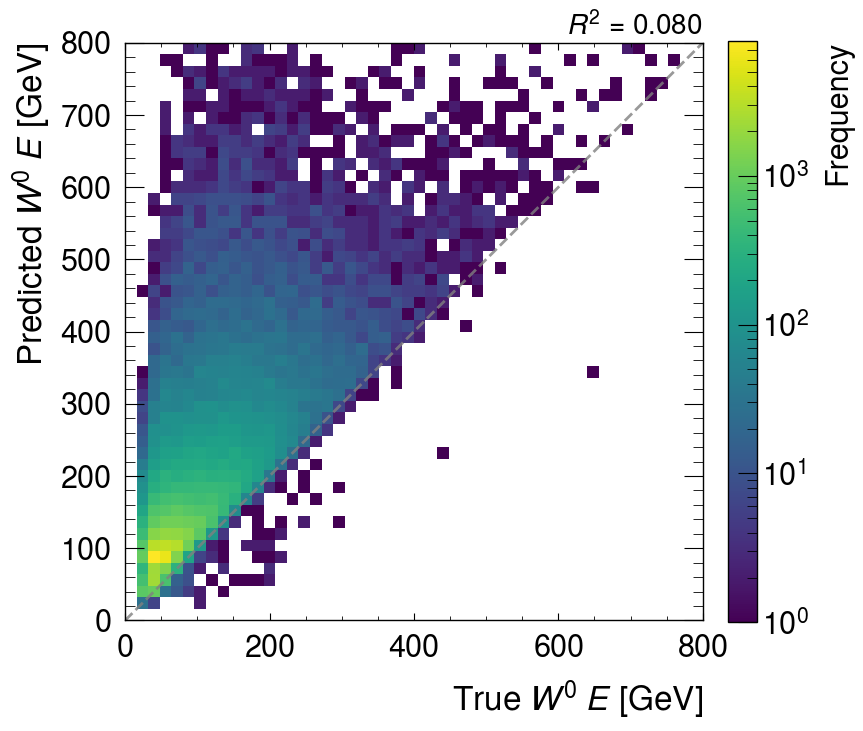

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist_1d(
    sig_truth_inv[:,3], sig_pred_inv[:,3],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ E$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,3], sig_pred_inv[:,3],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,3], sig_pred_inv[:,3]):.3f}",
    xlabel="True $W^{0}\ E$ [GeV]",
    ylabel="Predicted $W^{0}\ E$ [GeV]",
    ranges=set_range
)

True mean: 98.991, std: 77.608, min: 17.001, max: 1443.825


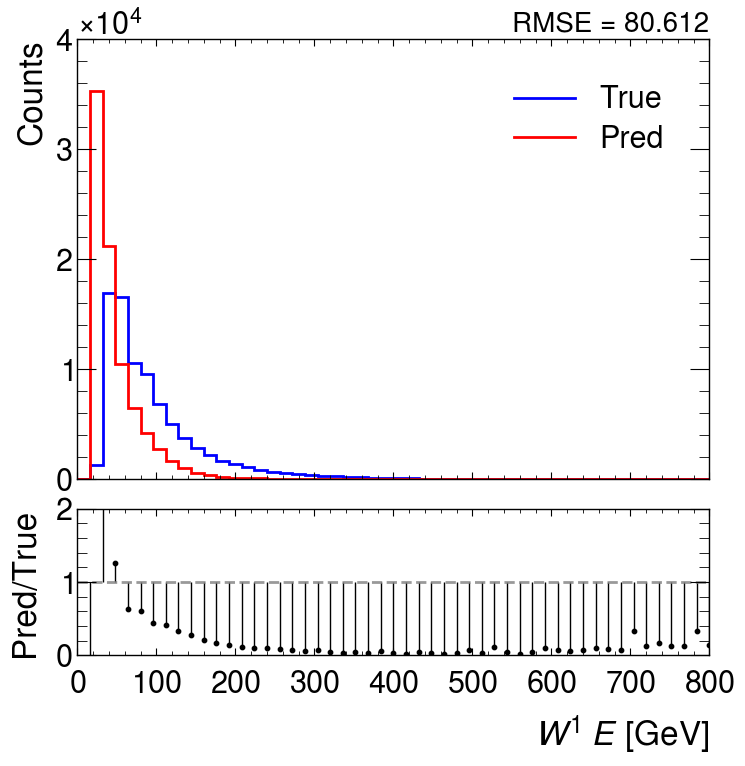

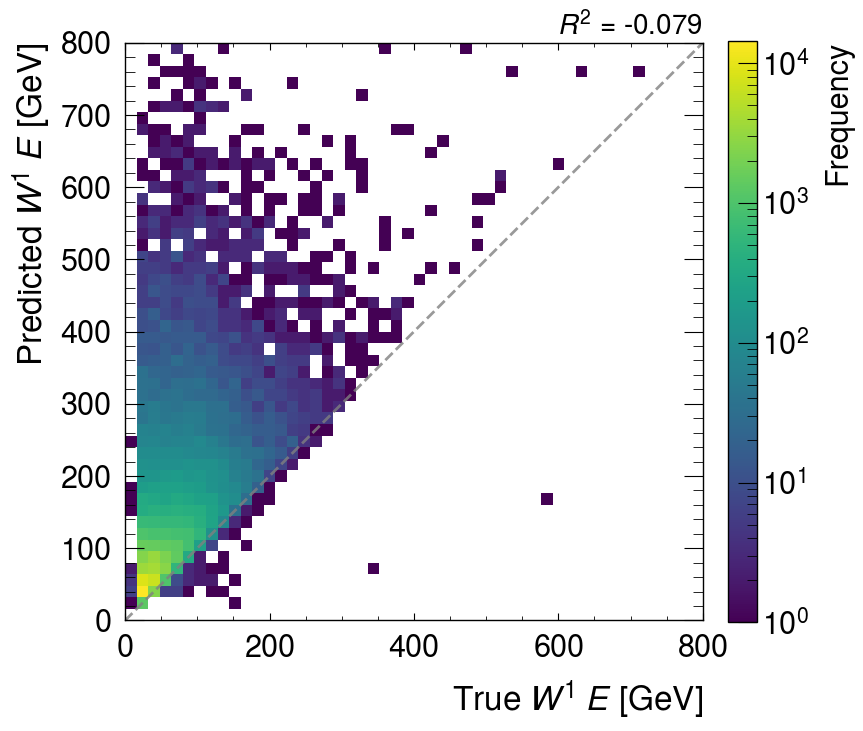

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 800]

plot.hist_1d(
    sig_truth_inv[:,7], sig_pred_inv[:,7],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ E$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,7], sig_pred_inv[:,7],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,7], sig_pred_inv[:,7]):.3f}",
    xlabel="True $W^{1}\ E$ [GeV]",
    ylabel="Predicted $W^{1}\ E$ [GeV]",
    ranges=set_range
)

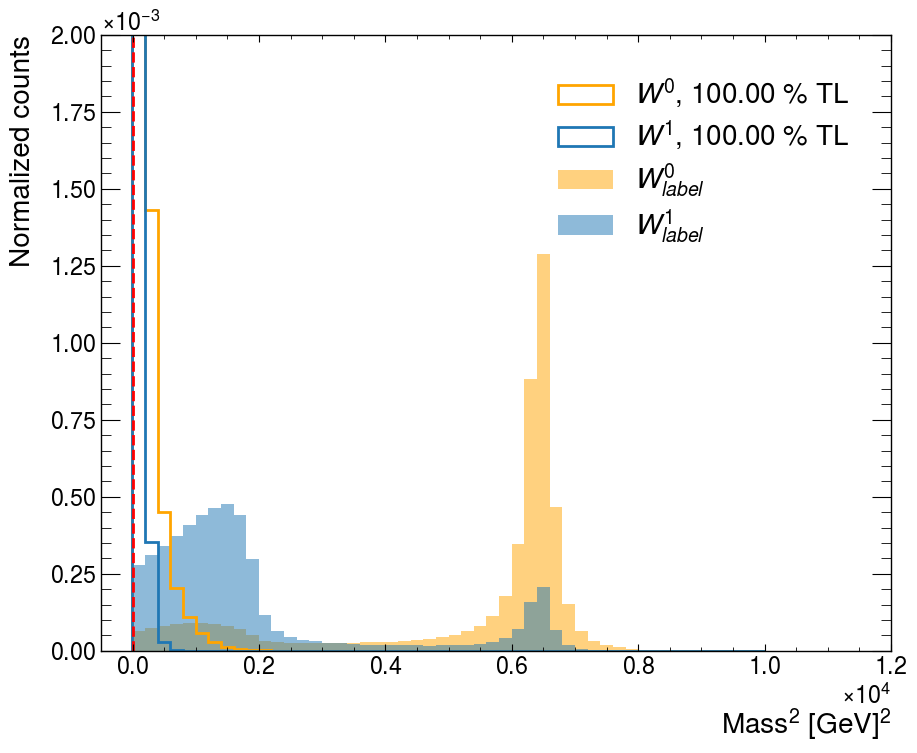

m2 with 100.00 % time-like (TL) evts


In [ ]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$, "
    + f"{100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$, "
    + f"{100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{0}$",
    density=True,
    # weights=mc_weight,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{1}$",
    density=True,
    # weights=mc_weight,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.legend(loc="upper right", prop={'size': 20})  # Adjust the size value as needed
plt.show()
print(f"m2 with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask):.2f} % time-like (TL) evts")

Truth mean: 3615.291, std: 2594.373, min: 4.010, max: 11077.988


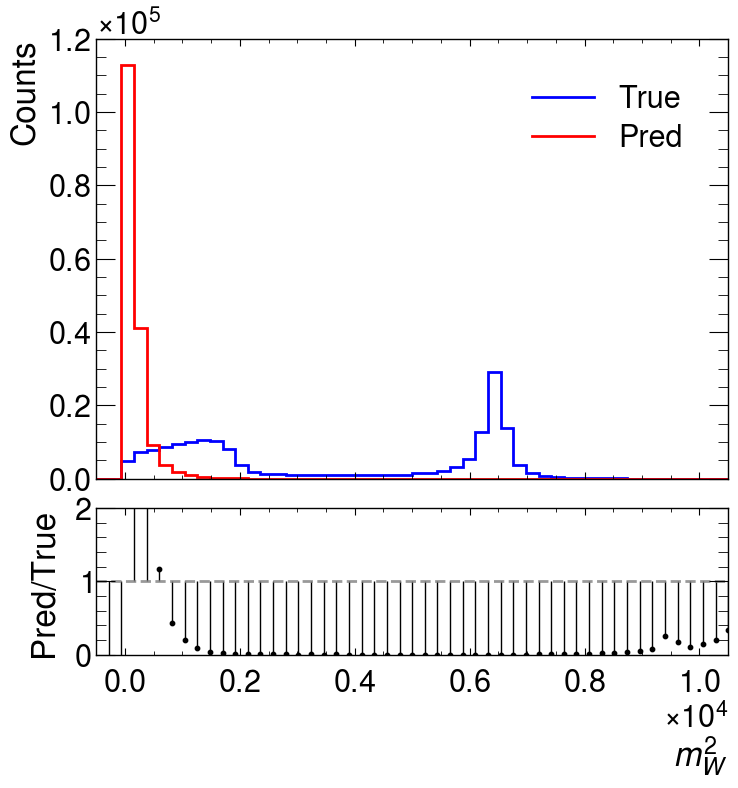

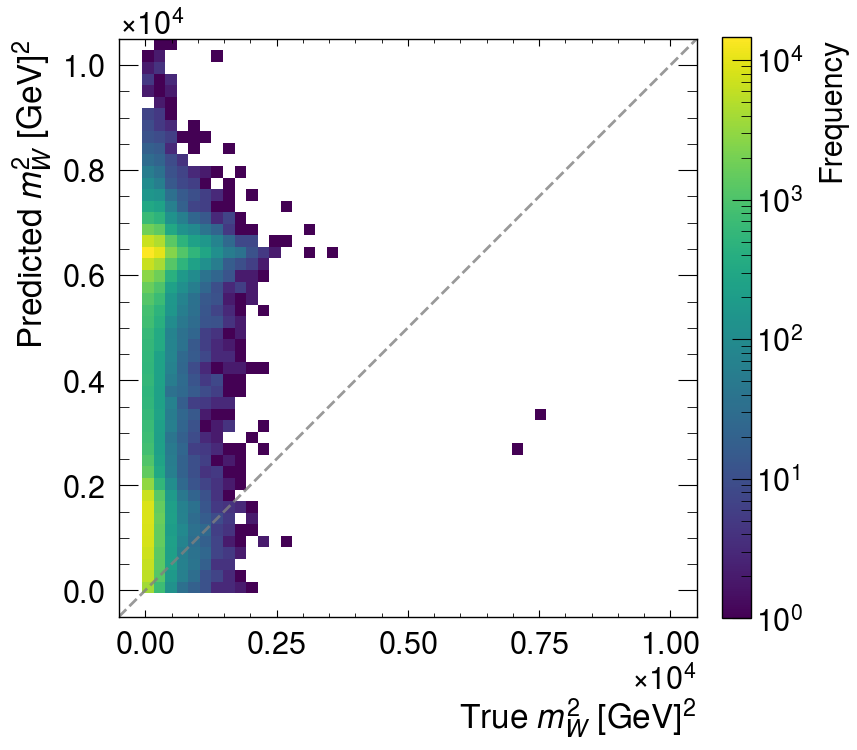

In [ ]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate(
    [np.square(w_lead.m)[test_indices], np.square(w_sublead.m)[test_indices]], axis=-1
)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]


plot.hist_1d(
    truth_m2, pred_m2,
    title="",
    xlabel=r"$m_{W}^{2}$",
    xpad=25,
    ranges=set_range
)

plot.hist_2d(
    truth_m2, pred_m2,
    title="",
    xlabel="True $m_{W}^{2}$ [GeV]$^2$",
    ylabel="Predicted $m_{W}^{2}$ [GeV]$^2$",
    xpad=25,
    ranges=set_range
)

In [ ]:

# TODO: CGLMP

def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
    )
    
def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))
    
    # Unpack the results
    bij, xi_p, xi_n = zip(*results)
    
    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_p[~mask, :],
        xi_n[~mask, :],
    )

In [ ]:
# reco
particles = np.concatenate(
    [
        sig_pred_inv[:, 0:4],
        lead_lep_p4[test_indices],
        sig_pred_inv[:, 4:8],
        sublead_lep_p4[test_indices],
    ],
    axis=1,
)
bij = result_generator(particles)[0][0:80_000,:]
xi_p = result_generator(particles)[1][0:80_000,:]
xi_n = result_generator(particles)[2][0:80_000,:]

# truth
particles = np.concatenate(
    [
        sig_truth_inv[:, 0:4],
        truth_lead_lep_p4[test_indices],
        sig_truth_inv[:, 4:8],
        truth_sublead_lep_p4[test_indices],
    ],
    axis=1,
)
truth_bij = result_generator(particles)[0][0:80_000,:]
truth_xi_p = result_generator(particles)[1][0:80_000,:]
truth_xi_n = result_generator(particles)[2][0:80_000,:]

True mean     : 2.468, std: 12.019, min: -25.100, max: 29.607
Predicted mean: 2.664, std: 3.745, min: -3.434, max: 24.590


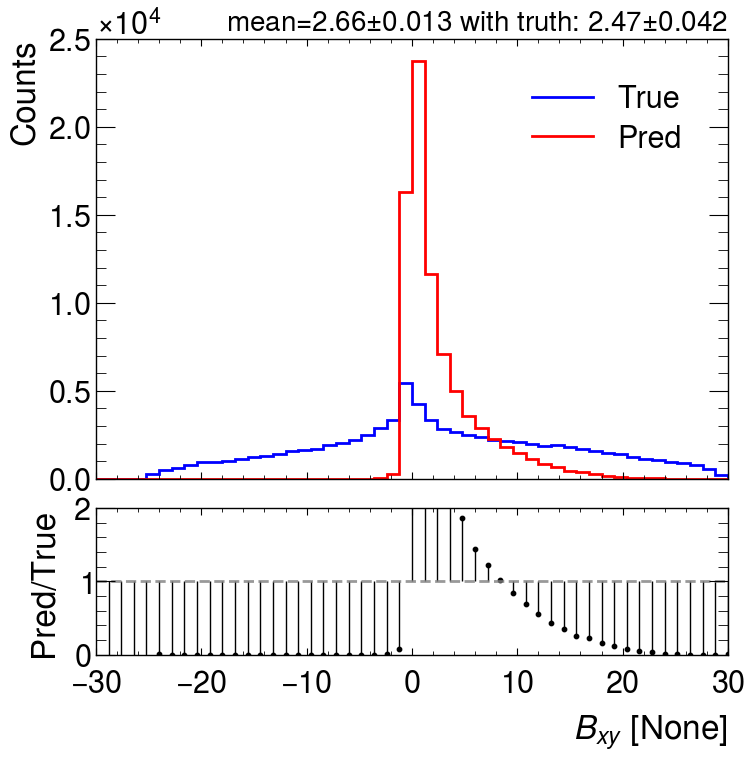

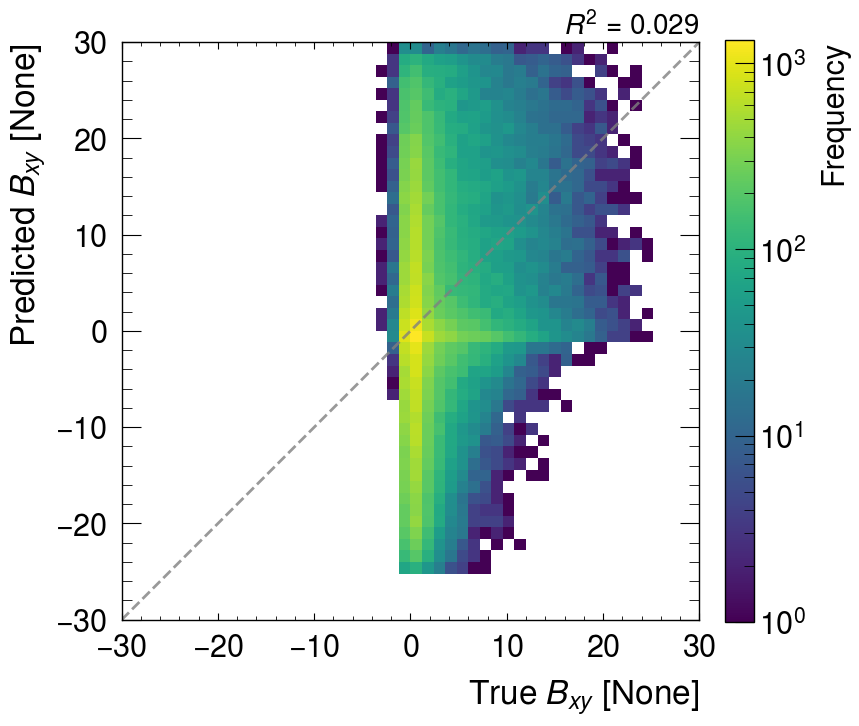

In [ ]:

print(
    f"True mean     : {np.mean(truth_bij[:,0]):.3f}, std: {np.std(truth_bij[:,0]):.3f}, min: {np.min(truth_bij[:,0]):.3f}, max: {np.max(truth_bij[:,0]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,0]):.3f}, std: {np.std(bij[:,0]):.3f}, min: {np.min(bij[:,0]):.3f}, max: {np.max(bij[:,0]):.3f}"
)

set_range = [-30, 30]

plot.hist_1d(
    truth_bij[:,0], bij[:,0],
    title=rf"mean={np.mean(bij[:,0]):.2f}$\pm${sp.stats.sem(bij[:,0]):.3f}"
    + f" with truth: {np.mean(truth_bij[:,0]):.2f}$\pm${sp.stats.sem(truth_bij[:,0]):.3f}",
    xlabel=r"$B_{xy}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,0], bij[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,0], bij[:,0]):.3f}",
    xlabel="True $B_{{xy}}$ [None]",
    ylabel="Predicted $B_{{xy}}$ [None]",
    ranges=set_range
)

True mean     : 2.060, std: 8.727, min: -25.095, max: 29.572
Predicted mean: -2.249, std: 13.512, min: -25.078, max: 22.312


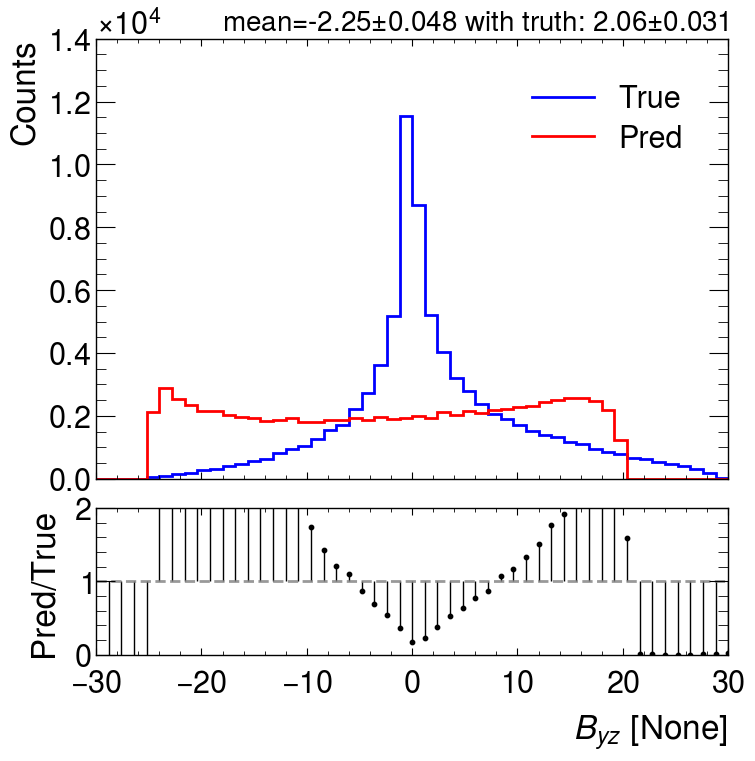

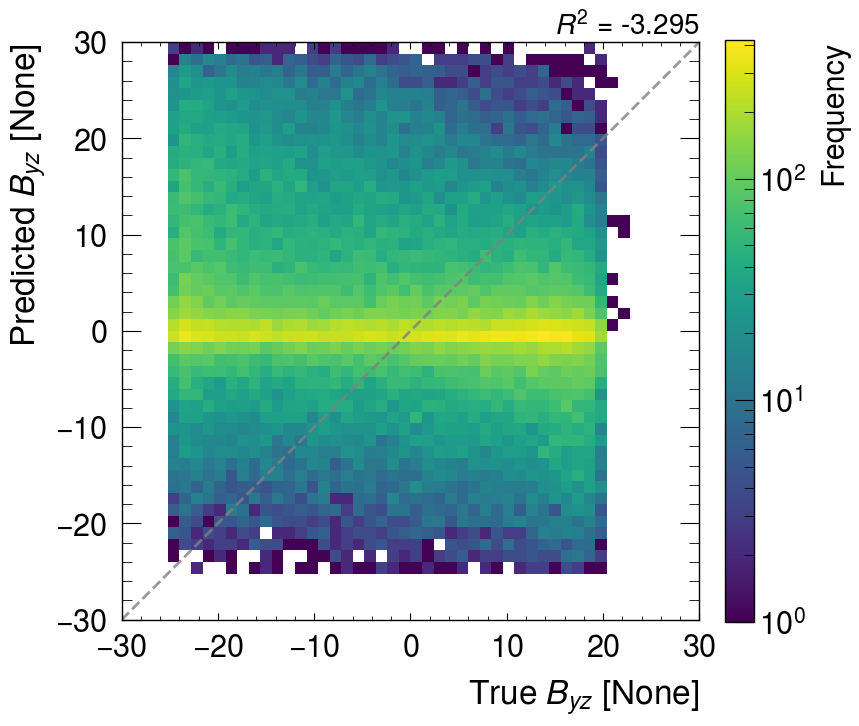

In [ ]:

print(
    f"True mean     : {np.mean(truth_bij[:,1]):.3f}, std: {np.std(truth_bij[:,1]):.3f}, min: {np.min(truth_bij[:,1]):.3f}, max: {np.max(truth_bij[:,1]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,1]):.3f}, std: {np.std(bij[:,1]):.3f}, min: {np.min(bij[:,1]):.3f}, max: {np.max(bij[:,1]):.3f}"
)

set_range = [-30, 30]


plot.hist_1d(
    truth_bij[:,1], bij[:,1],
    title=fr"mean={np.mean(bij[:,1]):.2f}$\pm${sp.stats.sem(bij[:,1]):.3f}"
    + f" with truth: {np.mean(truth_bij[:,1]):.2f}$\pm${sp.stats.sem(truth_bij[:,1]):.3f}",
    xlabel=r"$B_{yz}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,1], bij[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,1], bij[:,1]):.3f}",
    xlabel="True $B_{{yz}}$ [None]",
    ylabel="Predicted $B_{{yz}}$ [None]",
    ranges=set_range
)

True mean     : 3.228, std: 10.739, min: -25.073, max: 29.599
Predicted mean: 4.369, std: 9.351, min: -25.074, max: 20.380


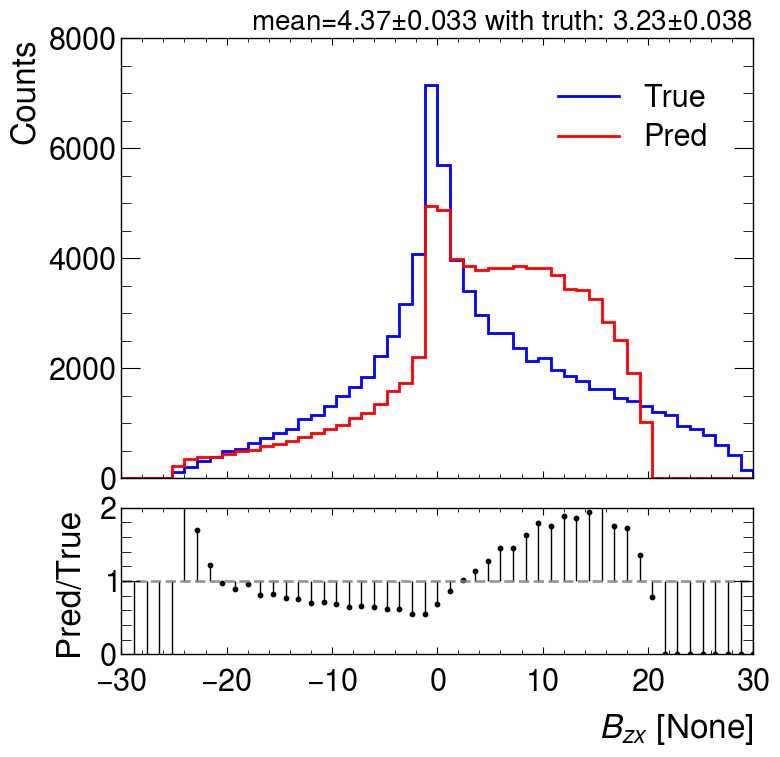

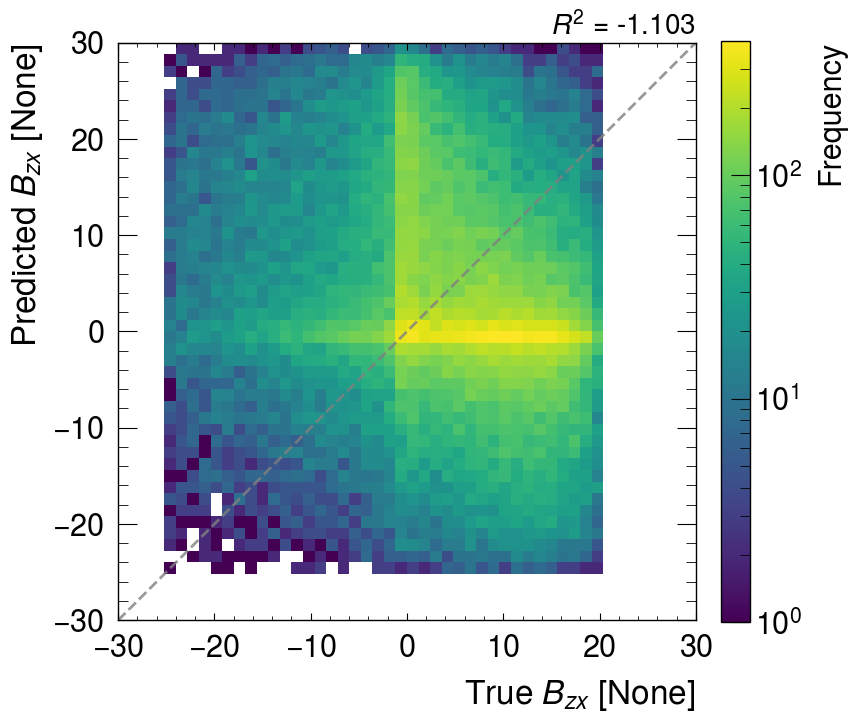

In [ ]:

print(
    f"True mean     : {np.mean(truth_bij[:,2]):.3f}, std: {np.std(truth_bij[:,2]):.3f}, min: {np.min(truth_bij[:,2]):.3f}, max: {np.max(truth_bij[:,2]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,2]):.3f}, std: {np.std(bij[:,2]):.3f}, min: {np.min(bij[:,2]):.3f}, max: {np.max(bij[:,2]):.3f}"
)

set_range = [-30, 30]

plot.hist_1d(
    truth_bij[:,2], bij[:,2],
    title=rf"mean={np.mean(bij[:,2]):.2f}$\pm${sp.stats.sem(bij[:,2]):.3f}"
    + rf" with truth: {np.mean(truth_bij[:,2]):.2f}$\pm${sp.stats.sem(truth_bij[:,2]):.3f}",
    xlabel=r"$B_{zx}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,2], bij[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,2], bij[:,2]):.3f}",
    xlabel=r"True $B_{{zx}}$ [None]",
    ylabel=r"Predicted $B_{{zx}}$ [None]",
    ranges=set_range
)

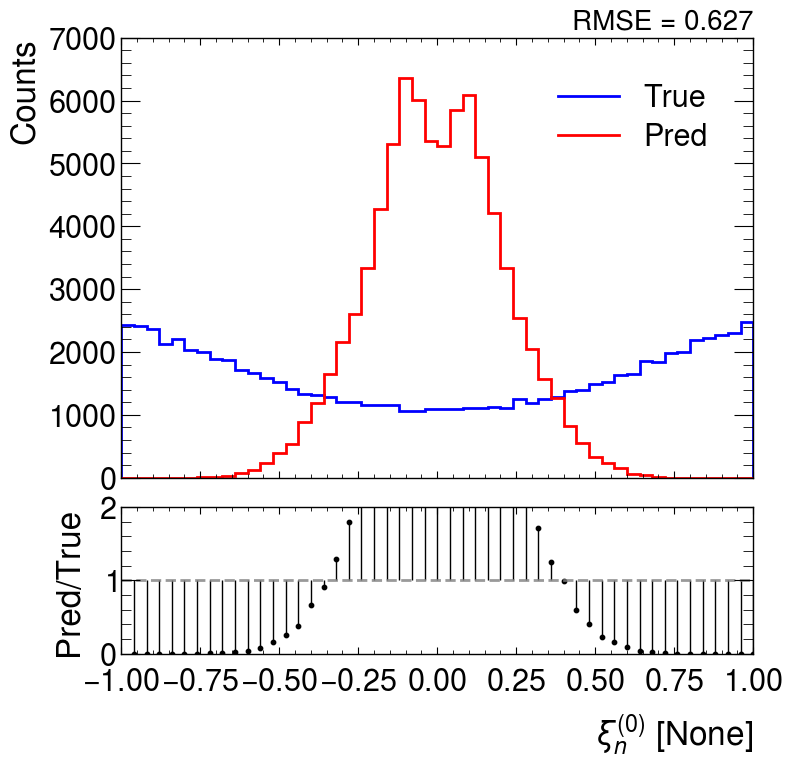

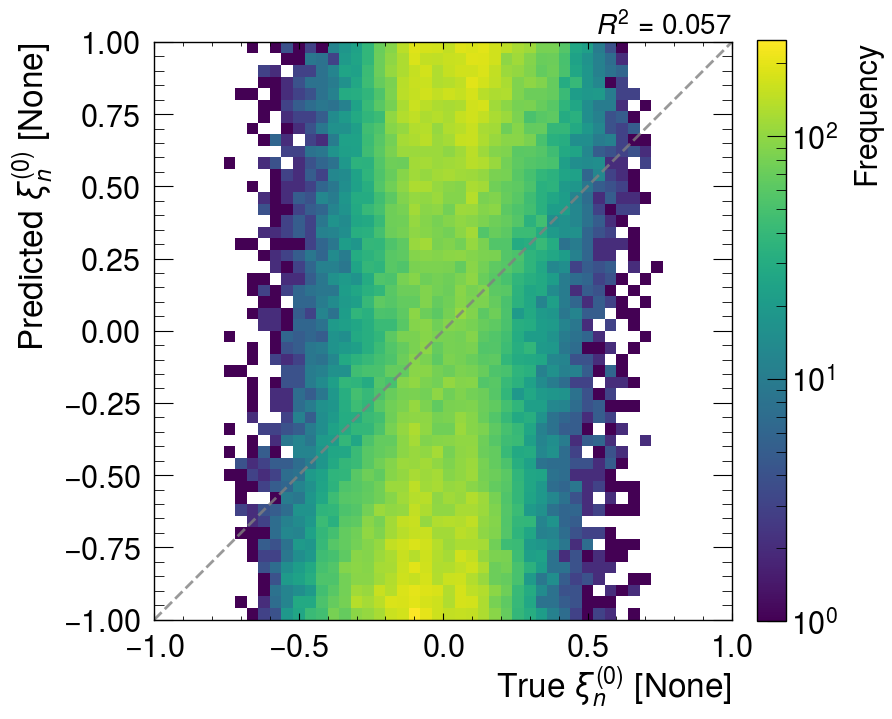

In [ ]:
set_range = [-1, 1]


plot.hist_1d(
    truth_xi_p[:,0], xi_p[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,0], xi_p[:,0], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{n}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,0], xi_p[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,0], xi_p[:,0]):.3f}",
    xlabel=r"True $\xi^{(0)}_{n}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{n}$ [None]",
    xpad=0,
    ranges=set_range
)

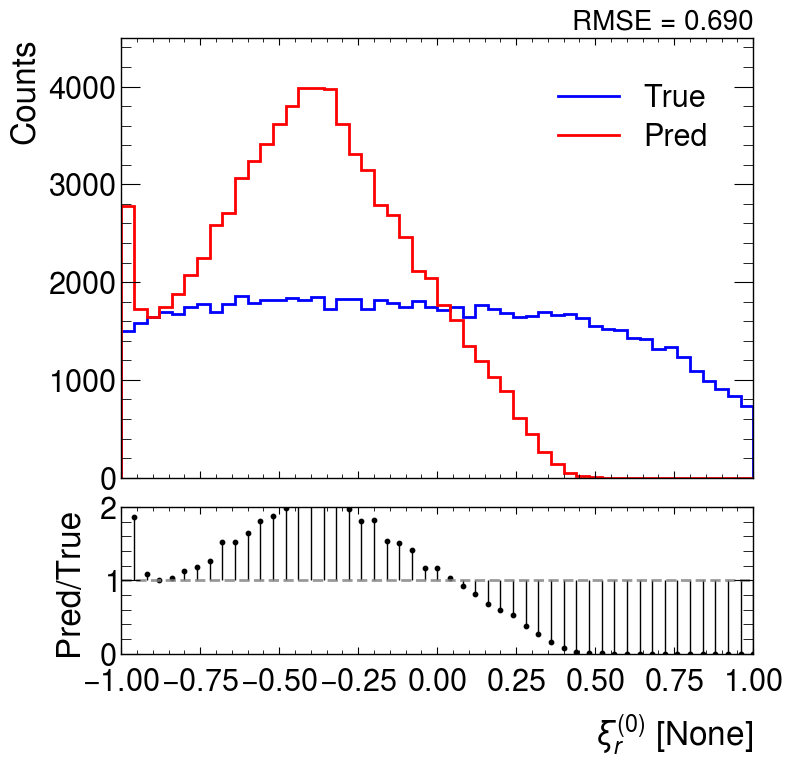

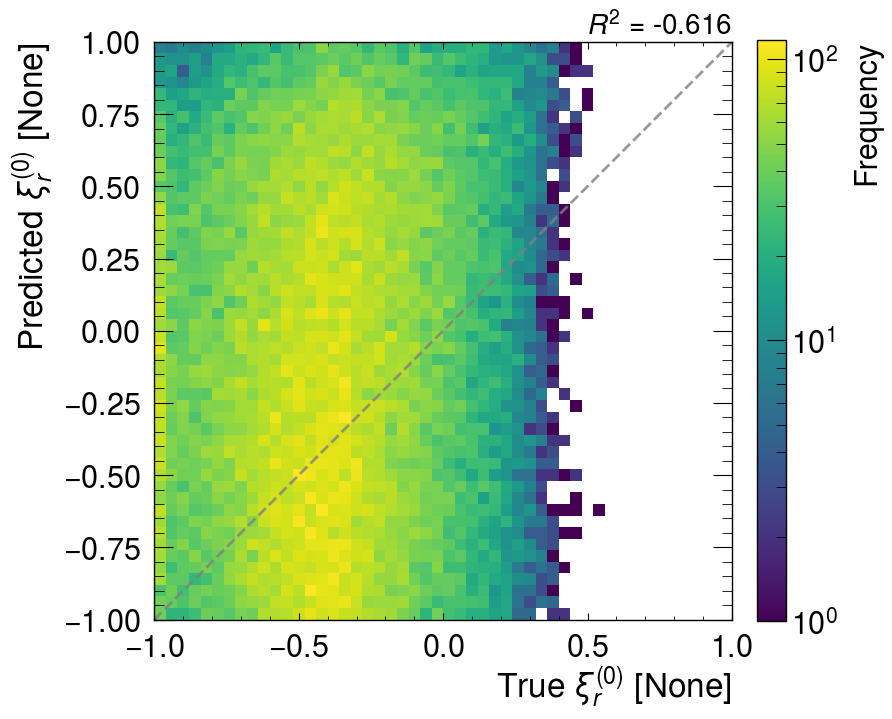

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_p[:,1], xi_p[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,1], xi_p[:,1], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{r}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,1], xi_p[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,1], xi_p[:,1]):.3f}",
    xlabel=r"True $\xi^{(0)}_{r}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{r}$ [None]",
    xpad=0,
    ranges=set_range
)

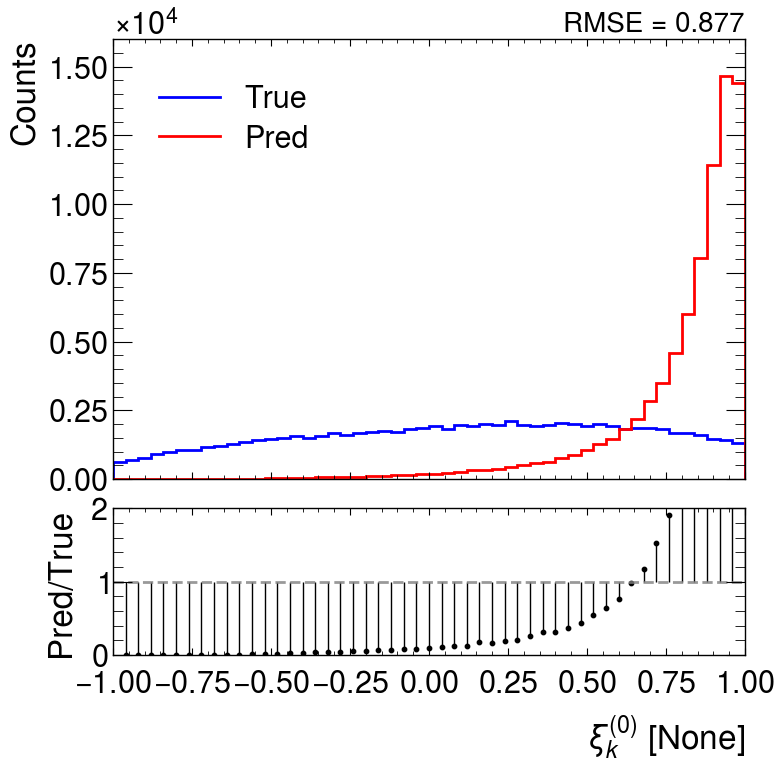

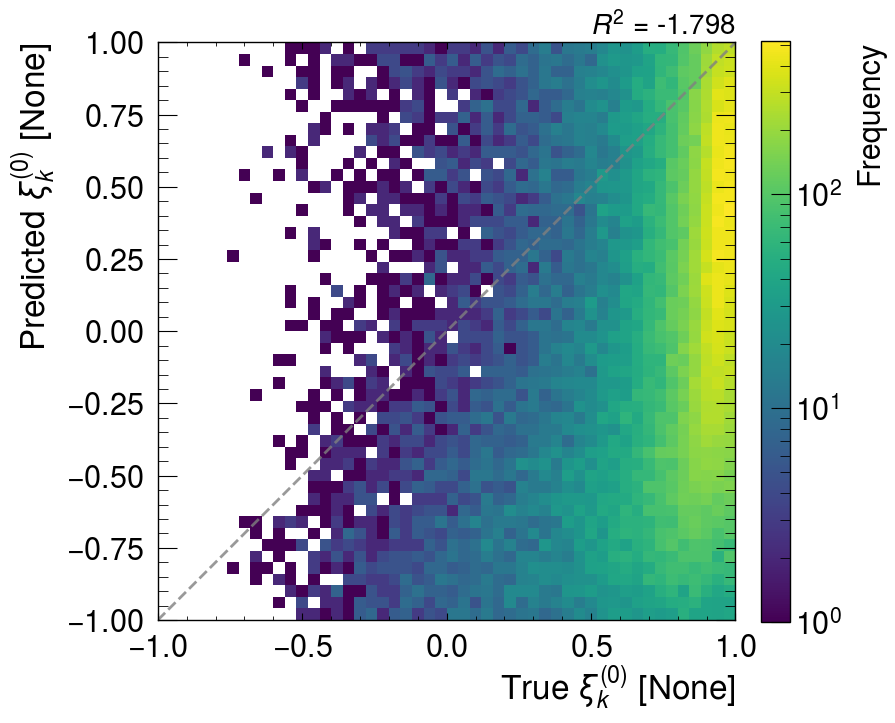

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_p[:,2], xi_p[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,2], xi_p[:,2], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{k}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,2], xi_p[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,2], xi_p[:,2]):.3f}",
    xlabel=r"True $\xi^{(0)}_{k}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{k}$ [None]",
    xpad=0,
    ranges=set_range
)

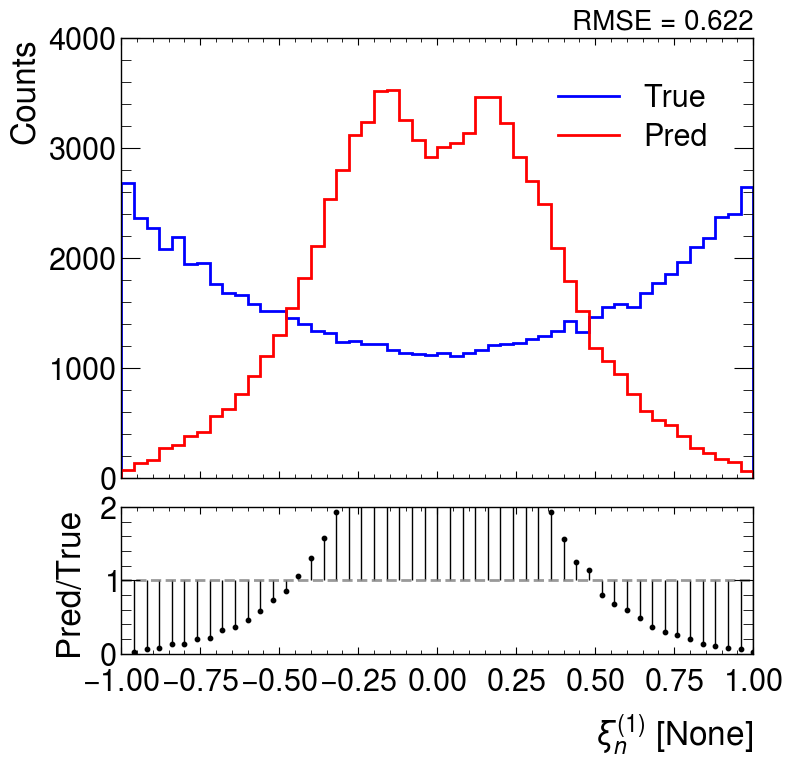

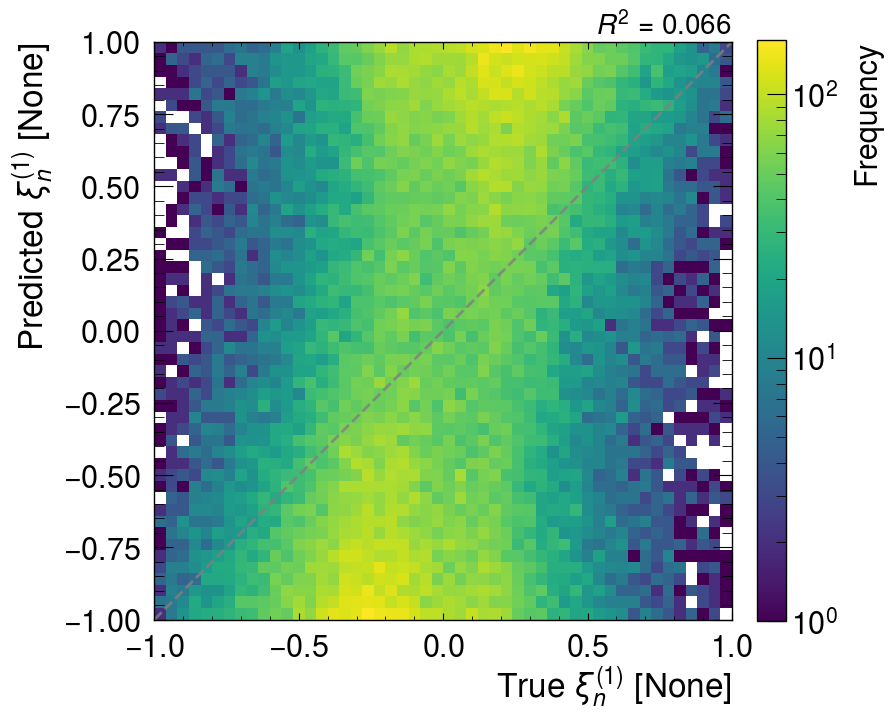

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,0], xi_n[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,0], xi_n[:,0], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{n}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,0], xi_n[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,0], xi_n[:,0]):.3f}",
    xlabel=r"True $\xi^{(1)}_{n}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{n}$ [None]",
    xpad=0,
    ranges=set_range
)

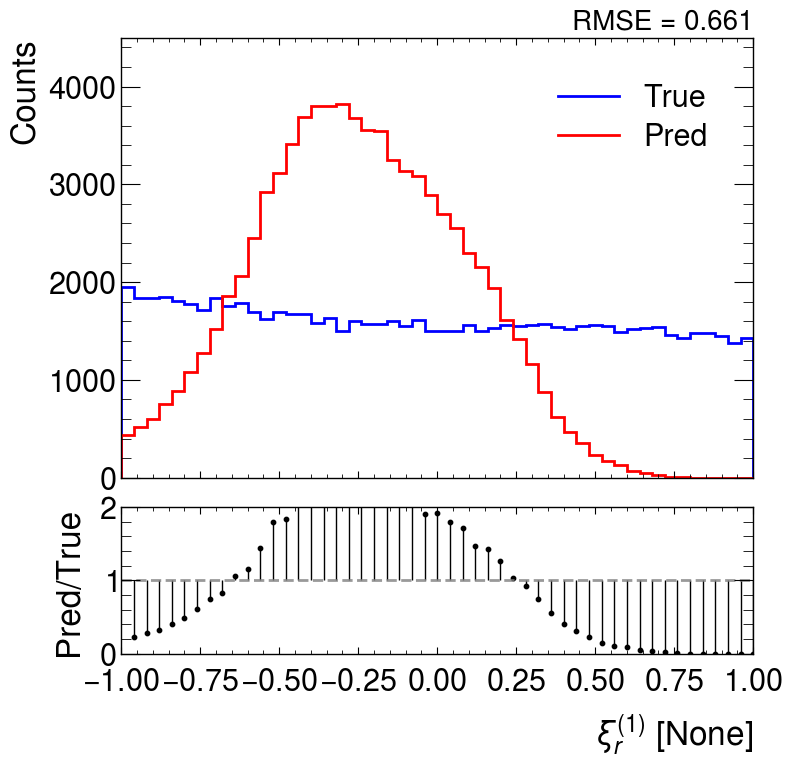

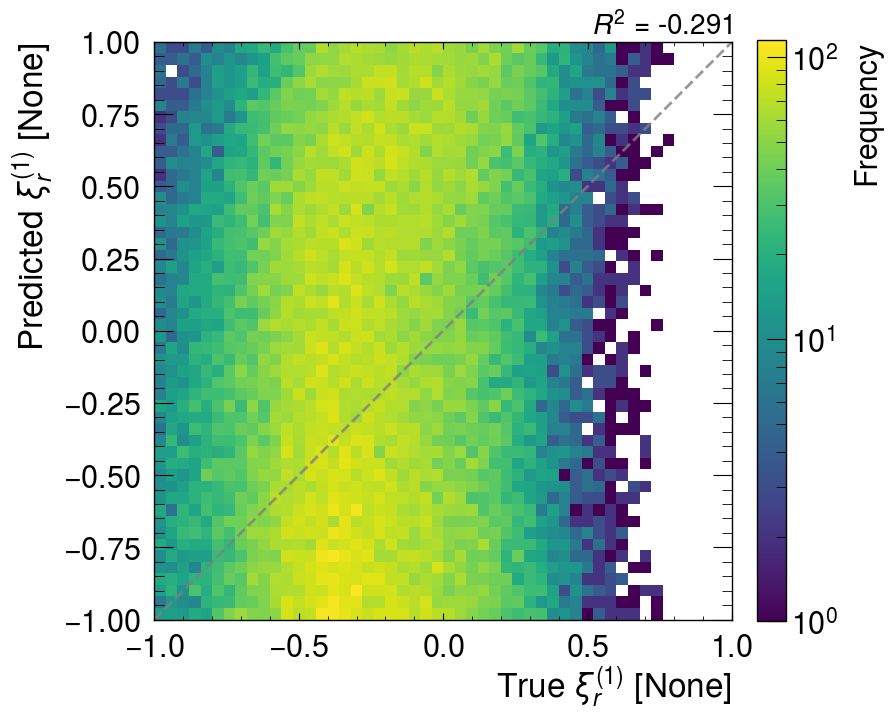

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,1], xi_n[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,1], xi_n[:,1], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{r}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,1], xi_n[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,1], xi_n[:,1]):.3f}",
    xlabel=r"True $\xi^{(1)}_{r}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{r}$ [None]",
    xpad=0,
    ranges=set_range
)

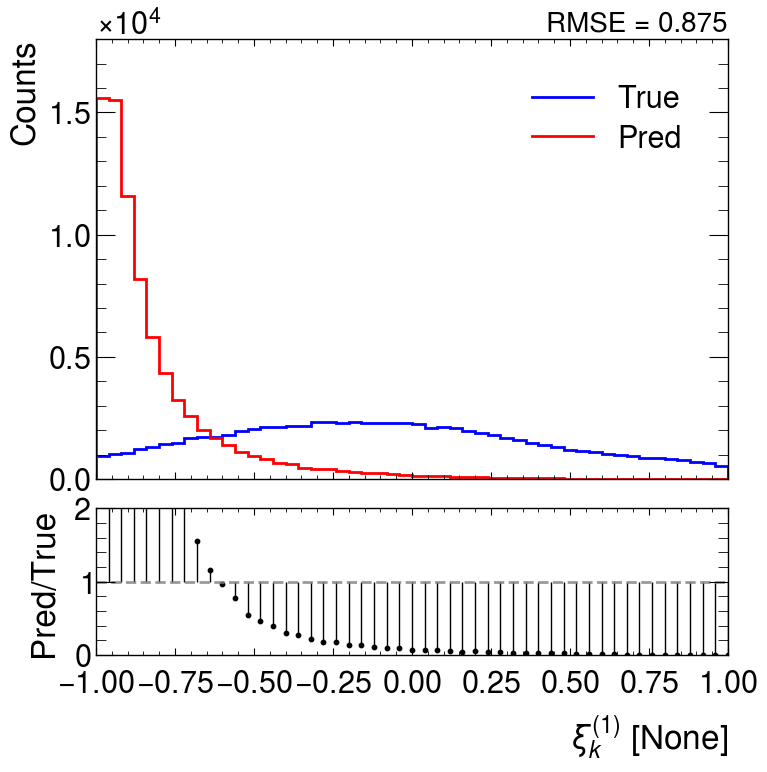

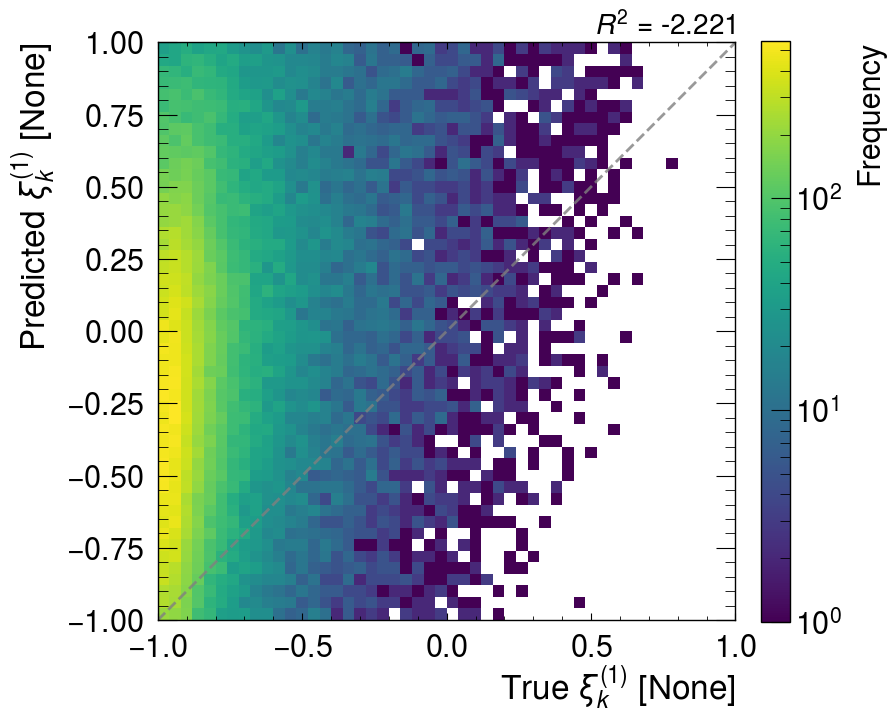

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,2], xi_n[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,2], xi_n[:,2], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{k}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,2], xi_n[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,2], xi_n[:,2]):.3f}",
    xlabel=r"True $\xi^{(1)}_{k}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{k}$ [None]",
    xpad=0,
    ranges=set_range
)